# RAG System Component Evaluation
    
This notebook is a follow up from the previous [notebook](https://github.com/fhuthmacher/LLMevaluation/blob/main/LLMInformationExtraction.ipynb) and [youtube video](https://www.youtube.com/watch?v=HUuO9eJbOTk) in which we explored the overall evaluation approach and a RAG system's overall accuracy.

In this notebook we will take a closer look at specific RAG evaluation metrics and explore how to optimize different RAG components based on these RAG evaluation metrics.


## Solution architecture
<img src="./images/architecture.png" alt="RAG eval architecture " width="800">

From the solution architecture, we will experiment with the below RAG components and parameters to optimize our RAG evalution metrics.

- Chunk Size: determines how a source text is stored in a knowledge base
- Chunking strategy / Text Splitter: TokenTextSplitter vs CharacterTextSplitter
- Embedding model: amazon.titan-embed-text-v1 & v3 vs cohere.embed-multilingual-v3 & cohere.embed-english-v3
- Retriever: OpenSearch VectoreStoreRetriever search types “similarity” vs “mmr” vs Bedrock KnowledgeBase retriever
- Prompt Template: set of instructions to guide the LLM’s response


## RAG evaluation metrics

This notebook covers the following metrics from Retrieval Augmented Generation Assessment (RAGAS):

-  context_precision: evaluates whether all of the ground-truth relevant items are present in the contexts are ranked higher or not. Ideally all the relevant chunks must appear at the top ranks. Values range from 0 to 1, higher scores indicate better precision.
-  context_recall: measures the extent to which the retrieved context aligns with the annotated answer, treated as the ground truth. Values range from 0 to 1, with higher values indicating better performance.
-  answer_relevancy: focuses on assessing how relevant the generated answer is to the given prompt. A lower score is assigned to answers that are incomplete or contain redundant information. This metric is computed using the question and the answer, with values ranging between 0 and 1 where higher scores indicate better relevancy.
-  answer_correctness¶: the accuracy of the generated answer when compared to the ground truth. This evaluation relies on the ground truth and the answer, with scores ranging from 0 to 1  where higher scores indicate better relevancy.
-  faithfulness: measures the factual consistency of the generated answer against the given context. It is calculated from answer and retrieved context. Values range from 0 to 1, with higher values indicating better performance.

Further information on RAG evaluation metrics with RAGAS can be found [here](https://docs.ragas.io/en/latest/concepts/metrics/index.html).


While this notebook tracks metrics with mlflow, it is not required for the evaluation. If you want to learn more about how to configure mlflow in your environment, please refer to this [AWS Blog](https://aws.amazon.com/blogs/machine-learning/securing-mlflow-in-aws-fine-grained-access-control-with-aws-native-services/).

In this notebook we use helper functions for illustration purposes. In production, this functionality would typically be part of an evaluation pipeline for example with Amazon SageMaker Pipelines.

<img src="./images/RAGevalmetrics.png" alt="RAG eval metrics" width="800">

In [1]:
# parse output of !conda env list and check if value rag_eval is part of it
import subprocess

# Run the command and capture its output
output = subprocess.check_output(["conda", "env", "list"])

# Decode the output from bytes to string
output = output.decode("utf-8")

# Split the output into lines
lines = output.split("\n")

# Iterate through the lines to find the environment names
environment_names = []
for line in lines:
    # Skip empty lines and lines not starting with a hash (#)
    if line.startswith("#") or not line.strip():
        continue
    # Split the line by whitespace and get the first element (environment name)
    environment_name = line.split()[0]
    environment_names.append(environment_name)

# Check if "rag_eval" is in the list of environment names
if "rag_eval" in environment_names:
    print("The environment 'rag_eval' is present.")
else:
    print("The environment 'rag_eval' is not present.")
    # Create a conda environment to encapsulate dependencies
    !conda env list
    !conda create -y --name rag_eval python=3.11.8 
    !conda init && activate rag_eval
    !conda install -n rag_eval ipykernel --update-deps --force-reinstall # if this fails, try running steps in terminal



The environment 'rag_eval' is present.


#### Please note, if the conda environment 'rag_eval' was not present and was just installed, do a browser refresh and select the new kernel.

In [2]:
# check installed packages
with open('requirements.txt') as f:
  requirements = f.readlines()

import pkg_resources

installed_packages = [d for d in pkg_resources.working_set]

installed_packages = [package.project_name for package in installed_packages]

missing_packages = []

for requirement in requirements:
  requirement = requirement.strip().split('==')[0]
  if requirement not in installed_packages:
      missing_packages.append(requirement)
if missing_packages:
  print(f"Missing packages: {', '.join(missing_packages)}")
else: 
  print("All packages are installed")

All packages are installed


In [3]:
# if there are any missing dependencies, install packages
if missing_packages:
    # install dependencies
    %pip install --force-reinstall --no-cache -r requirements.txt
    !pip install --upgrade jupyter-console
    !pip install --upgrade jupyter

In [4]:
# restart kernel to ensure proper version of libraries is loaded
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
if missing_packages:
    restartkernel()

In [5]:
!pip list | grep -E "awscli|boto3|botocore|langchain|llama-index|plotly|tiktoken|nltk|python-dotenv|ragas|requests-aws4auth|pypdf|opensearch-py|sagemaker|nest-asyncio"
# also review requirements.txt for specific package versions if needed

boto3                     1.34.87
botocore                  1.34.93
langchain                 0.1.16
langchain-aws             0.1.2
langchain-community       0.0.34
langchain-core            0.1.52
langchain-openai          0.1.6
langchain-text-splitters  0.0.1
langchainhub              0.1.15
nest-asyncio              1.6.0
nltk                      3.8.1
opensearch-py             2.4.2
plotly                    5.9.0
pypdf                     3.17.4
python-dotenv             1.0.0
ragas                     0.1.7
requests-aws4auth         1.2.3
sagemaker                 2.203.1
tiktoken                  0.5.2


In [42]:
# load environment variables 
import boto3
import os
import botocore
from botocore.config import Config
import langchain
import sagemaker
import pandas as pd

from langchain.llms.bedrock import Bedrock
from langchain.llms import SagemakerEndpoint
from langchain.llms.sagemaker_endpoint import LLMContentHandler
from typing import Dict

import json
import requests
import csv
import time
import pandas as pd
import nltk
import sys

from langchain.llms import Bedrock
from dotenv import load_dotenv, find_dotenv
import mlflow
from mlflow import MlflowClient

import random
random_identifier = random.randint(100,999)

# loading environment variables that are stored in local file dev.env
local_env_filename = 'dev-rageval.env'
load_dotenv(find_dotenv(local_env_filename),override=True)

os.environ['OPENSEARCH_COLLECTION'] = os.getenv('OPENSEARCH_COLLECTION')
os.environ['BEDROCK_KNOWLEDGEBASE_ID'] = os.getenv('BEDROCK_KNOWLEDGEBASE_ID')
os.environ['REGION'] = os.getenv('REGION')
os.environ['MLFLOW_TRACKING_ENABLED'] = os.getenv('MLFLOW_TRACKING_ENABLED')
os.environ['MLFLOW_TRACKING_URI'] = os.getenv('MLFLOW_TRACKING_URI')

if os.environ['MLFLOW_TRACKING_ENABLED'] == 'True':
   # Initialize mlflow client
   mlflow_client = MlflowClient(tracking_uri=os.environ['MLFLOW_TRACKING_URI'])


# Initialize Bedrock runtime
config = Config(
   retries = {
      'max_attempts': 10,
      'mode': 'standard'
   }
)
bedrock_runtime = boto3.client(
        service_name="bedrock-runtime",
        config=config
)
bedrock_client = boto3.client(
        service_name="bedrock",
        config=config
)

# Initialize sagemaker session
session = sagemaker.Session()
bucket = session.default_bucket()

In [41]:
# Create a new mlflow experiment if mlflow tracking is enabled
if os.environ['MLFLOW_TRACKING_ENABLED'] == 'True':
    experiment_description = (
        "RAG system evaluation project."
    )

    experiment_tags = {
        "project_name": "rag-eval",
        "use_case": "information extraction",
        "team": "aws-ai-ml-analytics",
        "source": "Amazon 10k",
        "mlflow.note.content": experiment_description,
    }

    experiment_name = f"RAG_system_accuracy_{random_identifier}"

    # Use search_experiments() to search on the project_name tag key
    rag_experiment = mlflow_client.search_experiments(
        filter_string="tags.`project_name` = 'rag-eval'"
    )
    # check length of mlflow.store.entities.paged_list.PagedList
    # if experiment does not exist yet, create it
    if len(rag_experiment) == 0:
        rag_experiment = mlflow_client.create_experiment(name=experiment_name, tags=experiment_tags)
        print(rag_experiment)
else:
    print(f'mflow is disabled')
    experiment_name = 'not_tracked'


mflow is disabled


In [4]:
## 1. Download ground truth dataset

import xmltodict
url = 'https://d3q8adh3y5sxpk.cloudfront.net/rageval/qsdata_20.xml'

# Send an HTTP GET request to download the file
response = requests.get(url)

# Check if the request was successful (HTTP status code 200)
if response.status_code == 200:        
    xml_data = xmltodict.parse(response.text)

# Convert the dictionary to a Pandas DataFrame
qa_dataset = pd.DataFrame(xml_data['data']['records'])

prompts = []
for row in qa_dataset.itertuples():
    item = {
        'prompt': str(row[1]['Question']),
        'context': str(row[1]['Context']),
        'output': '<question_answer>' + str(row[1]['Answer']['question_answer']) + '</question_answer>',
        'page': str(row[1]['Page'])
    }
    prompts.append(item)

# example prompt
print(prompts[0])

{'prompt': "Who is Amazon's Senior Vice President and General Counsel?", 'context': 'Available Information\nOur investor relations website is amazon.com/ir and we encourage investors to use it as a way of easily finding information about us. We promptly make available on this website, free of charge, the reports that we file or furnish with the Securities and Exchange Commission (â\x80\x9cSECâ\x80\x9d), corporate governance information (including our Code of Business Conduct and Ethics), and select press releases.\nExecutive Officers and Directors\nThe following tables set forth certain information regarding our Executive Officers and Directors as of January 25, 2023:\nInformation About Our Executive Officers\nName Age Position\nJeffrey P. Bezos. Mr. Bezos founded Amazon.com in 1994 and has served as Executive Chair since July 2021. He has served as Chair of the Board since 1994 and served as Chief Executive Officer from May 1996 until July 2021, and as President from 1994 until June 1

In [5]:
# 2. Download context / Amazon annual report and create documents
import numpy as np
import pypdf
from langchain.text_splitter import CharacterTextSplitter, TokenTextSplitter, RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader, PyPDFDirectoryLoader
from urllib.request import urlretrieve

os.makedirs("data", exist_ok=True)
files = [ "https://d3q8adh3y5sxpk.cloudfront.net/rageval/AMZN-2023-10k.pdf"]
for url in files:
    file_path = os.path.join("data", url.rpartition("/")[2])
    urlretrieve(url, file_path)
    

loader = PyPDFDirectoryLoader("./data/")
documents = loader.load()

In [44]:
# 3. Create or get vector database (OpenSearch Serverless)
## Provisioning below resources requires signficant access. 
## Thus if you do not have admin access or already have an existing OpenSearch Serverless endpoint and Bedrock Knowledge Base, you can just update the corresponding variable in dev-mlflow.env

import time
import os
import dotenv
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth

host = os.environ['OPENSEARCH_COLLECTION']  # serverless collection endpoint, without https://
#print(f"host: {host}")
region = os.environ['REGION']  # e.g. us-east-1
print(f'region: {region}')

service = 'aoss'
credentials = boto3.Session().get_credentials()
auth = AWSV4SignerAuth(credentials, region, service)

aoss_client = boto3.client('opensearchserverless')
bedrock_agent_client = boto3.client('bedrock-agent', region_name = region)

## 4a. create vectordatabase if it does not exist yet
if host == 'XXX':
    print('creating collection')
    vector_store_name = 'rag-eval'
    encryption_policy_name = "rag-eval-ep"
    network_policy_name = "rag-eval-np"
    access_policy_name = 'rag-eval-ap'
    identity = boto3.client('sts').get_caller_identity()['Arn']

    

    security_policy = aoss_client.create_security_policy(
        name = encryption_policy_name,
        policy = json.dumps(
            {
                'Rules': [{'Resource': ['collection/' + vector_store_name],
                'ResourceType': 'collection'}],
                'AWSOwnedKey': True
            }),
        type = 'encryption'
    )

    network_policy = aoss_client.create_security_policy(
        name = network_policy_name,
        policy = json.dumps(
            [
                {'Rules': [{'Resource': ['collection/' + vector_store_name],
                'ResourceType': 'collection'}],
                'AllowFromPublic': True}
            ]),
        type = 'network'
    )

    collection = aoss_client.create_collection(name=vector_store_name,type='VECTORSEARCH')

    while True:
        status = aoss_client.list_collections(collectionFilters={'name':vector_store_name})['collectionSummaries'][0]['status']
        if status in ('ACTIVE', 'FAILED'): 
            print(f'new collection {vector_store_name} created')
            break
        time.sleep(10)

    access_policy = aoss_client.create_access_policy(
        name = access_policy_name,
        policy = json.dumps(
            [
                {
                    'Rules': [
                        {
                            'Resource': ['collection/' + vector_store_name],
                            'Permission': [
                                'aoss:CreateCollectionItems',
                                'aoss:DeleteCollectionItems',
                                'aoss:UpdateCollectionItems',
                                'aoss:DescribeCollectionItems'],
                            'ResourceType': 'collection'
                        },
                        {
                            'Resource': ['index/' + vector_store_name + '/*'],
                            'Permission': [
                                'aoss:CreateIndex',
                                'aoss:DeleteIndex',
                                'aoss:UpdateIndex',
                                'aoss:DescribeIndex',
                                'aoss:ReadDocument',
                                'aoss:WriteDocument'],
                            'ResourceType': 'index'
                        }],
                    'Principal': [identity],
                    'Description': 'Easy data policy'}
            ]),
        type = 'data'
    )
    print(collection)
    host = collection['createCollectionDetail']['id'] + '.' + os.environ.get("AWS_DEFAULT_REGION", None) + '.aoss.amazonaws.com:443'
    host = host.split(":")[0].replace("'","")
    # Write changes to .env file.
    os.environ['OPENSEARCH_COLLECTION'] = host
    dotenv.set_key(local_env_filename, "OPENSEARCH_COLLECTION", os.environ["OPENSEARCH_COLLECTION"])

aospy_client = OpenSearch(
    hosts=[{'host': host, 'port': 443}],
    http_auth=auth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    pool_maxsize=20,
)

## 4b. create Bedrock KnowledgeBase if it does not exist yet

if os.environ['BEDROCK_KNOWLEDGEBASE_ID'] == "XXX":
    knowledge_base_id = ""
    session = sagemaker.Session()

    # please note this requires significant permissions, thus might have to be done outside of the notebook if your user role has insufficient access.
    print('create knowledge base')

    print(f'using the following S3 bucket as source: {bucket}')
    prefix = "bedrock-kb-eval"

    # upload source data to S3
    s3 = boto3.client('s3')
    s3.upload_file('./data/AMZN-2023-10k.pdf', bucket, 'rageval/AMZN-2023-10k.pdf')

    knowledge_base_name = prefix + str(random_identifier)
    knowledge_base_description = prefix
    
    knowledge_base_bucket_arn = f"arn:aws:s3:::{bucket}"
    # parse collection id
    collection_id = os.environ['OPENSEARCH_COLLECTION'].split(".")[0]
    account_id = boto3.Session().client('sts').get_caller_identity()['Account']

    collection_arn = f'arn:aws:aoss:{region}:{account_id}:collection/{collection_id}'
    embeddingModelArn = f"arn:aws:bedrock:{region}::foundation-model/cohere.embed-multilingual-v3"

    # create IAM role
    iam = boto3.client('iam')
    policy_doc = {
        "Version": "2012-10-17",
        "Statement": [
            {
                "Effect": "Allow", 
                "Action": [
                    "s3:GetObject",
                    "s3:PutObject",
                    "s3:ListBucket"
                ],
                "Resource": [
                    f"arn:aws:s3:::{bucket}",
                    f"arn:aws:s3:::{bucket}/*"  
                ]
            },
            {
                "Sid": "BedrockAll",
                "Effect": "Allow",
                "Action": [
                    "bedrock:*"
                ],
                "Resource": "*"
            },
            {
                "Sid": "PassRoleToBedrock",
                "Effect": "Allow",
                "Action": [
                    "iam:PassRole"
                ],
                "Resource": "arn:aws:iam::*:role/*AmazonBedrock*",
                "Condition": {
                    "StringEquals": {
                        "iam:PassedToService": [
                            "bedrock.amazonaws.com"
                        ]
                    }
                }
            },
            {
            "Effect": "Allow",
            "Action": [
                "aoss:APIAccessAll",
                "aoss:*"
            ],
            "Resource": f'arn:aws:aoss:{region}:{account_id}:collection/{collection_id}'
            }
        ]
        }
    
    rolename = f'AmazonBedrockExecutionRoleForKnowledgeBase_rageval{str(random_identifier)}'
    role = iam.create_role(
        RoleName=rolename,
        AssumeRolePolicyDocument=json.dumps({
            "Version": "2012-10-17",
            "Statement": [
                {
                    "Effect": "Allow",
                    "Principal": {
                    "Service": [
                        "bedrock.amazonaws.com",
                        "opensearchservice.amazonaws.com"
                    ]
                    },  
                    "Action": "sts:AssumeRole"
                }
            ]
        })
    )

    result = iam.put_role_policy(
        RoleName=rolename,
        PolicyName='AmazonBedrockExecutionRolePolicy',
        PolicyDocument=json.dumps(policy_doc)
    )
    role_details = iam.get_role(RoleName=rolename)

    knowledge_base_resource_role_arn = role_details['Role']['Arn']

    # create OpenSearch index
    index_name = prefix
    vector_field = "kb_vector"
    text_field = "kb_text"
    bedrock_metadata_field = "bedrock"
    vector_size = 1024


    #create a new index
    index_body = {
        "settings": {
            "index.knn": True
    },
    'mappings': {
        'properties': {
        f"{vector_field}": { "type": "knn_vector", "dimension": vector_size, "method": {"engine": "faiss", "space_type": "l2", "name": "hnsw", "parameters": {}   } },
        f"{text_field}": { "type": "text" },
        f"{bedrock_metadata_field}": { "type": "text", "index": False }
        }
    }
    }
    
    
    # wait for index creation to complete
    from opensearchpy.exceptions import NotFoundError, AuthorizationException
    index_create = False 
    while True:
        try:
            if index_create == False:
                aospy_client.indices.create(index=index_name,body=index_body)
                index_create = True
            response = aospy_client.indices.get(index=index_name)
            print(response)
            if response[f'{index_name}']: 
                print(f'new index {index_name} has been created.')
                break
        except:
            print(f'keep waiting for new index {index_name} creation')
            time.sleep(10)

    print(f'knowledge_base_name: {knowledge_base_name}')
    print(f'knowledge_base_description: {knowledge_base_description}')
    print(f'knowledge_base_resource_role_arn: {knowledge_base_resource_role_arn}')
    print(f'embeddingModelArn: {embeddingModelArn}')
    print(f'collection_arn: {collection_arn}')
    print(f'index_name: {index_name}')
    print(f'vector_field: {vector_field}')
    print(f'text_field: {text_field}')
    print(f'bedrock_metadata_field: {bedrock_metadata_field}')

    # add Bedrock KB role to OpenSearch Serverless access policy
    access_policy_get = aoss_client.get_access_policy(
            name = access_policy_name,
            type = 'data')

    access_policy_version = access_policy_get['accessPolicyDetail']['policyVersion']
    print(access_policy_version)

    access_policy = aoss_client.update_access_policy(
        name = access_policy_name,
        policyVersion = access_policy_version,
        policy = json.dumps(
            [
                {
                    'Rules': [
                        {
                            'Resource': ['collection/' + vector_store_name],
                            'Permission': [
                                'aoss:CreateCollectionItems',
                                'aoss:DeleteCollectionItems',
                                'aoss:UpdateCollectionItems',
                                'aoss:DescribeCollectionItems'],
                            'ResourceType': 'collection'
                        },
                        {
                            'Resource': ['index/' + vector_store_name + '/*'],
                            'Permission': [
                                'aoss:CreateIndex',
                                'aoss:DeleteIndex',
                                'aoss:UpdateIndex',
                                'aoss:DescribeIndex',
                                'aoss:ReadDocument',
                                'aoss:WriteDocument'],
                            'ResourceType': 'index'
                        }],
                    'Principal': [identity,knowledge_base_resource_role_arn],
                    'Description': 'Easy data policy'}
            ]),
        type = 'data'
    )

    # create knowledge base
    knowledge_base_config = {
        "name": knowledge_base_name,
        "description": knowledge_base_description,
        "roleArn":knowledge_base_resource_role_arn,
        "knowledgeBaseConfiguration": {
            "type": 'VECTOR',
            "vectorKnowledgeBaseConfiguration": {
                "embeddingModelArn": embeddingModelArn
            }
        },
        "storageConfiguration": {
            "type": 'OPENSEARCH_SERVERLESS',
            "opensearchServerlessConfiguration": {
                "collectionArn": collection_arn,
                "vectorIndexName": index_name,
                "fieldMapping": {
                    "vectorField": vector_field,
                    "textField": text_field,
                    "metadataField": bedrock_metadata_field
                }
            }
        }
    }
    
    # wait for knowledge base creation to complete
    knowledge_base_id = ''
    while True:
        try:
            if knowledge_base_id == '':
                kbresponse = bedrock_agent_client.create_knowledge_base(**knowledge_base_config)
                knowledge_base_id = kbresponse['knowledgeBase']['knowledgeBaseId']
            response = bedrock_agent_client.get_knowledge_base(knowledgeBaseId = knowledge_base_id)
            
            if response['knowledgeBase']['status'] == 'ACTIVE' or 'FAILED': 
                print(f"new knowledgeBaseId {knowledge_base_id} has been in status {response['knowledgeBase']['status']}.")
                break
        except:
            print(f'keep waiting for new knowledgeBaseId {knowledge_base_id} creation to complete')
            time.sleep(10)                  

    data_source_id = ""
    max_token_chunk = 300
    overlap = 10

    # configure data_source
    data_source_name = knowledge_base_name
    data_source_config = {
        "knowledgeBaseId": knowledge_base_id,
        "name": data_source_name,
        "description": data_source_name,
        "dataSourceConfiguration": {
            "type": 'S3',
            "s3Configuration": {
                "bucketArn": knowledge_base_bucket_arn,
                "inclusionPrefixes": [
                    "rageval/",
                ]
            }
        },
        "vectorIngestionConfiguration": {
            "chunkingConfiguration": {
                "chunkingStrategy": "FIXED_SIZE",
                "fixedSizeChunkingConfiguration": {
                    "maxTokens": max_token_chunk,
                    "overlapPercentage": overlap
                }
            }
        }
    }

    # wait for knowledge base data source creation to complete
    data_source_id = ''
    while True:
        try:
            if data_source_id == '':
                ds_response = bedrock_agent_client.create_data_source(**data_source_config)
                data_source_id = ds_response['dataSource']['dataSourceId']
                print(f"data_source_id: {data_source_id}")

            response = bedrock_agent_client.get_data_source(knowledgeBaseId = knowledge_base_id, dataSourceId = data_source_id)
            
            if response['dataSource']['status'] == 'ACTIVE' or 'FAILED': 
                print(f"new dataSourceId {data_source_id} has been in status {response['dataSource']['status']}.")
                break
        except:
            print(f'keep waiting for new dataSourceId {data_source_id} creation to complete')
            time.sleep(10)
    
    time.sleep(10)
    ingestion_response = bedrock_agent_client.start_ingestion_job(knowledgeBaseId=knowledge_base_id,dataSourceId=data_source_id)
    print(f"ingestion response: {ingestion_response}")
    
    ingestion_job = ingestion_response['ingestionJob']['ingestionJobId']
    print(f"ingestionJobId: {ingestion_job}")
    status = 'IN_PROGRESS'
    response = {}
    
    while status == 'IN_PROGRESS':
        response = bedrock_agent_client.get_ingestion_job(
            knowledgeBaseId=knowledge_base_id,
            dataSourceId=data_source_id,
            ingestionJobId=ingestion_job
        )
        
        status = response['ingestionJob']['status']
        time.sleep(5)
    
    print(response['ingestionJob']['statistics'])

    # Write changes to .env file.
    os.environ['BEDROCK_KNOWLEDGEBASE_ID'] = knowledge_base_id
    dotenv.set_key(local_env_filename, "BEDROCK_KNOWLEDGEBASE_ID", os.environ["BEDROCK_KNOWLEDGEBASE_ID"])

region: us-east-1
creating collection
new collection rag-eval created
{'createCollectionDetail': {'arn': 'arn:aws:aoss:us-east-1:026459568683:collection/inrll2ecmxejndtzsige', 'createdDate': 1715736646740, 'id': 'inrll2ecmxejndtzsige', 'kmsKeyArn': 'auto', 'lastModifiedDate': 1715736646740, 'name': 'rag-eval', 'standbyReplicas': 'ENABLED', 'status': 'CREATING', 'type': 'VECTORSEARCH'}, 'ResponseMetadata': {'RequestId': 'b8905e50-29a9-46e7-99ac-ca09e0b13535', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'b8905e50-29a9-46e7-99ac-ca09e0b13535', 'date': 'Wed, 15 May 2024 01:30:46 GMT', 'content-type': 'application/x-amz-json-1.0', 'content-length': '300', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}
create knowledge base
using the following S3 bucket as source: sagemaker-us-east-1-026459568683
keep waiting for new index bedrock-kb-eval creation
keep waiting for new index bedrock-kb-eval creation
keep waiting for new index bedrock-kb-eval creation
{'bedrock-kb-eval': {'al

In [7]:
# 4. prompt templates for evaluation

### Claude prompt templates
# Template 1: Long prompt with XML tags context chunks, and step by step instructions, and reiterating how the response should be provided in the end.
prompt_template_claude_1 = """
        Human: 
        You are a helpful, respectful, and honest research assistant, dedicated to providing valuable and accurate information.
        You will be provided with a report extract between <report></report> XML tags, please read it and analyse the content.
        Please answer the following question: 
        {question} 
        
        The answer must only be based on the information from the report.
        Return the answer inside <question_answer></question_answer> XML tags.

        If a particular bit of information is not present, return "There is not enough information available to answer this question" inside the XML tags.
        Each returned answer should be concise, remove extra information if possible.
        The report will be given between <report></report> XML tags.

        <report>
        {context}
        </report>

        Return the answer inside <question_answer></question_answer> XML tags.
        Assistant:"""

# Template 2: InContextLearning prompt with example interaction between Human and Assistant
prompt_template_claude_2 = """
        Human: 
        You are a helpful, respectful, and honest research assistant, dedicated to providing valuable and accurate information.

        Assistant:
        Understood. I will provide information based on the context given, without relying on prior knowledge.

        Human:
        If you don't see answer in the context just reply "There is not enough information available to answer this question" in XML tags.

        Assistant:
        Noted. I will respond with "There is not enough information available to answer this question" if the information is not available in the context.

        Human:
        Return the answer inside <question_answer></question_answer> XML tags. 

        Assistant:
        I will provide the answer inside <question_answer></question_answer> XML tags.

        Human:
        Now read and analyse the context provided in <report></report> XML tags carefully.
        <report>
        {context}
        </report>
        Then answer the below question:
        {question}

        Assistant:<question_answer>
        """

### Llama2 prompt templates
prompt_template_llama_1 = """
        [INST] Given report provided, please read it and analyse the content.
        Please answer the following question: {question} basing the answer only on the information from the report
        and return it inside <question_answer></question_answer> XML tags.

        If a particular bit of information is not present, return an empty string.
        Each returned answer should be concise, remove extra information if possible.
        The report will be given between <report></report> XML tags.

        <report>
        {context}
        </report>

        Return the answer inside <question_answer></question_answer> XML tags. [/INST]
        """


prompt_template_llama_2 = """
        [INST]
        You are a helpful, respectful, and honest assistant, dedicated to providing valuable and accurate information.
        [/INST]

        Understood. I will provide information based on the context given, without relying on prior knowledge.

        [INST]
        If you don't see answer in the context just reply "not available" in XML tags.
        [/INST]

        Noted. I will respond with "not available" if the information is not available in the context.

        [INST]
        Now read this context and answer the question and return the answer inside <question_answer></question_answer> XML tags. 
        {context}
        [/INST]

        Based on the provided context above and information from the retriever source, I will provide the answer in  and return it inside <question_answer></question_answer> XML tags to the below question
        {question}
        """

### Cohere Command prompt templates
prompt_template_command_1 = """
        Human: Given report provided, please read it and analyse the content.
        Please answer the following question: {question} basing the answer only on the information from the report
        and return it inside <question_answer></question_answer> XML tags.

        If a particular bit of information is not present, return an empty string.
        Each returned answer should be concise, remove extra information if possible.
        The report will be given between <report></report> XML tags.

        <report>
        {context}
        </report>

        Return the answer inside <question_answer></question_answer> XML tags.
        Assistant:"""

prompt_template_command_2 = """
        Human: 
        You are a helpful, respectful, and honest assistant, dedicated to providing valuable and accurate information.

        Assistant:
        Understood. I will provide information based on the context given, without relying on prior knowledge.

        Human:
        If you don't see answer in the context just reply "not available" in XML tags.

        Assistant:
        Noted. I will respond with "not available" if the information is not available in the context.

        Human:
        Now read this context and answer the question and return the answer inside <question_answer></question_answer> XML tags. 
        {context}

        Assistant:
        Based on the provided context above and information from the retriever source, I will provide the answer in  and return it inside <question_answer></question_answer> XML tags to the below question
        {question}
        """


## 5) Create helper functions:
### 5a. RAG Agent Helper Class for RAG creation
### 5b. RAGAS Helper Class to use RAGAS with Amazon Bedrock
### 5C. RAGAS Eval Helper Class for evaluation of RAG system

In [8]:
# 5a. RAG Agent Helper Class
from anthropic import Anthropic
import time
from typing import List
from abc import ABC, abstractmethod
import boto3
import json
import os
from dataclasses import dataclass
import tiktoken 
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import pandas as pd
import numpy as np
from enum import Enum
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth
from langchain.text_splitter import CharacterTextSplitter, TokenTextSplitter, RecursiveCharacterTextSplitter
from langchain_community.utils.math import cosine_similarity

class DistanceStrategy(str, Enum):
    '''
    Enumerator of the Distance strategies for calculating distances between vectors.
    '''
    EUCLIDEAN_DISTANCE = "EUCLIDEAN_DISTANCE"
    MAX_INNER_PRODUCT = "MAX_INNER_PRODUCT"
    DOT_PRODUCT = "DOT_PRODUCT"
    JACCARD = "JACCARD"
    COSINE = "COSINE"

@dataclass
class RagAnswer():
    '''
    RAG answer structure
    '''
    answer: str
    context_list: List[str]
    query_time: float
    usage: int
    cost: float

class RagAgent(ABC):
    def __init__(
        self,
        model_id: str = 'anthropic.claude-3-haiku-20240307-v1:0',
        embedding_model_id: str = 'amazon.titan-embed-text-v1',
        top_k: int = 20,
        top_p: float = 0.7,
        temperature: float = 0.0,
        max_token_count: int = 4000,
        anthropic_version: str = 'bedrock-2023-05-31',
        prompt_template: str = '',
        search_method: str = 'approximate_search', # 'approximate_search' / 'mmr' / 'bedrock_kb'
        knowledge_base_id: str = '',
        region: str = 'us-east-1',
        opensearch_endpoint: str = '',
        opensearch_index: str = 'rag_eval',
        opensearch_index_dimension: int = 1536,
        opensearch_fetch_k: int = 4, # OpenSearch default
        documents: [] = [],
        chunking_strategy: str = 'TokenTextSplitter', # RecursiveCharacterTextSplitter / TokenTextSplitter
        chunk_size: int = 2000, 
        chunk_overlap: int = 260,
        debug: bool = False

    ):
        self.model_id = model_id
        self.embedding_model_id = embedding_model_id
        self.top_k = top_k
        self.top_p = top_p
        self.temperature = temperature
        self.max_token_count = max_token_count
        self.anthropic_version = anthropic_version
        self.prompt_template = prompt_template
        self.search_method = search_method
        self.knowledge_base_id = knowledge_base_id
        self.region = region
        self.opensearch_endpoint = opensearch_endpoint
        self.opensearch_index = opensearch_index
        self.opensearch_index_dimension = opensearch_index_dimension
        self.opensearch_fetch_k = opensearch_fetch_k
        self.documents = documents
        self.chunking_strategy = chunking_strategy
        self.chunk_size =  chunk_size
        self.chunk_overlap = chunk_overlap
        self.debug = debug

        self.bedrock_agent_runtime = boto3.client(
            service_name="bedrock-agent-runtime"
        )
        self.bedrock_runtime = boto3.client(
            service_name="bedrock-runtime"
        )
        self.anthropic_client = Anthropic()

        credentials = boto3.Session().get_credentials()
        auth = AWSV4SignerAuth(credentials, self.region, 'aoss')
        self.aos_client = OpenSearch(
            hosts=[{'host': self.opensearch_endpoint, 'port': 443}],
            http_auth=auth,
            use_ssl=True,
            verify_certs=True,
            connection_class=RequestsHttpConnection,
            pool_maxsize=20,
        )
    
    def count_tokens(text):
        '''
        using Anthropic library client to count tokens of a given text
        '''
        return self.anthropic_client.count_tokens(text)
    
    def calculate_cost(self, usage, model_id):
        '''
        Takes the usage tokens returned by Bedrock in input and output, and coverts to cost in dollars.
        '''
        input_token_haiku = 0.25/1000000
        output_token_haiku = 1.25/1000000
        input_token_sonnet = 3.00/1000000
        output_token_sonnet = 15.00/1000000
        input_token_opus = 15.00/1000000
        output_token_opus = 75.00/1000000
        cost = 0

        if 'haiku' in model_id:
            cost+= usage['input_tokens']*input_token_haiku
            cost+= usage['output_tokens']*output_token_haiku
        if 'sonnet' in model_id:
            cost+= usage['input_tokens']*input_token_sonnet
            cost+= usage['output_tokens']*output_token_sonnet
        if 'opus' in model_id:
            cost+= usage['input_tokens']*input_token_opus
            cost+= usage['output_tokens']*output_token_opus

        return cost
    
    def get_chunks(self, documents, chunking_strategy, chunk_size, chunk_overlap):
        '''
        using Langchain textsplitter implementations to split array of documents into chunks
        '''
        if chunking_strategy == 'RecursiveCharacterTextSplitter':
            char_text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
            chunk_list = char_text_splitter.split_documents(self.documents)
            
        if chunking_strategy == 'TokenTextSplitter':
            token_text_splitter = TokenTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
            chunk_list = token_text_splitter.split_documents(self.documents)

        final_chunk_list = []
        for chunk in chunk_list:
            final_chunk_list.append(chunk.page_content)

        return final_chunk_list

    def get_best_practice_chunks(full_text, OVERLAP=True):
        '''
        This will take a text and return an array with sliced chunks of the text following some general best practices:
        1) Overlaping allows more cohesion between text, and should only be turned off when trying to count specific numbers and no duplicated text is a requirment.
        2) Dropping text up to the maximum context window of a model, doesn't work very well.Part of the reason for this is because no matter the input length,
           the output length is about the same. For example, if you drop in a paragraph or 10 pages, you get about a paragraph in response.
        3) To mitigate this, we use chunks that are the lesser of two values: 25% of the total token count or 2k tokens.
           We'll also overlap our chunks by about a paragraph of text or so, in order to provide continuity between chunks.
           (Logic taken from https://gist.github.com/Donavan/4fdb489a467efdc1faac0077a151407a)
        '''
        
        #Following testing, it was found that chunks should be 2000 tokens, or 25% of the doc, whichever is shorter.
        #max chunk size in tokens
        chunk_length_tokens = 2000
        #chunk length may be shortened later for shorter docs.
        
        #a paragraph is about 200 words, which is about 260 tokens on average
        #we'll overlap our chunks by a paragraph to provide cohesion.
        overlap_tokens = 260
        if not OVERLAP: overlap_tokens = 0
        
        #anything this short doesn't need to be chunked further.
        min_chunk_length = 260 + overlap_tokens*2
        
        #grab basic info about the text to be chunked.
        char_count = len(full_text)
        word_count = len(full_text.split(" "))#rough estimate
        token_count = count_tokens(full_text)
        token_per_charater = token_count/char_count

        #don't chunk tiny texts
        if token_count <= min_chunk_length:
            if self.debug: print("Text is too small to be chunked further")
            return [full_text]
        
        if self.debug:
            print ("Chunk DEBUG mode is on, information about the text and chunking will be printed out.")
            print ("Estimated character count:",char_count)
            print ("Estimated word count:",word_count)
            print ("Estimated token count:",token_count)
            print ("Estimated tokens per character:",token_per_charater)

            print("Full text tokens: ",count_tokens(full_text))
            print("How many times bigger than max context window: ",round(count_tokens(full_text)/max_token_count,2))
        
        #if the text is shorter, use smaller chunks
        if (token_count/4<chunk_length_tokens):
            overlap_tokens = int((overlap_tokens/chunk_length_tokens)*int(token_count/4))
            chunk_length_tokens = int(token_count/4)
            
            if self.debug: 
                print("Short doc detected:")
                print("New chunk length:",chunk_length_tokens)
                print("New overlap length:",overlap_tokens)
            
        #convert to characters for easy slicing using our approximate tokens per character for this text.
        overlap_chars = int(overlap_tokens/token_per_charater)
        chunk_length_chars = int(chunk_length_tokens/token_per_charater)
        
        #itterate and create the chunks from the full text.
        chunks = []
        start_chunk = 0
        end_chunk = chunk_length_chars + overlap_chars
        
        last_chunk = False
        while not last_chunk:
            #the last chunk may not be the full length.
            if(end_chunk>=char_count):
                end_chunk=char_count
                last_chunk=True
            chunks.append(full_text[start_chunk:end_chunk])
            
            #move our slice location
            if start_chunk == 0:
                start_chunk += chunk_length_chars - overlap_chars
            else:
                start_chunk += chunk_length_chars

            end_chunk = start_chunk + chunk_length_chars + 2 * overlap_chars
            
        if self.debug:
            print ("Created %s chunks."%len(chunks))
        return chunks
    
    def get_embedding(self, body):
        '''
        This function is used to generate the embeddings for a specific chunk of text
        '''
        accept = 'application/json'
        contentType = 'application/json'
    
        response = self.bedrock_runtime.invoke_model(body=body, 
                                                        modelId=self.embedding_model_id, 
                                                        accept=accept, 
                                                        contentType=contentType)
    
        response_body = json.loads(response.get('body').read())
        
        return response_body

    def index_doc(self, vectors, text):
        '''
        This function is used to ingest a single chunk/document embedding into OpenSearch Serverless
        '''       
        indexDocument = {
            "vector_field": vectors,
            "text": text

        }
        try:
            response = self.aos_client.index(
                index=self.opensearch_index,
                body=indexDocument,
                refresh=False
            )

            return response
        except Exception as e:
            print(f'error: {e}')

    def index_documents(self,documents):
        '''
        This function is used to create an OpenSearch index, and then ingest all documents
        '''  
        self.documents = documents

        # create OpenSearch index
        knn_index = {
            "settings": {
                "index.knn": True
            },
            "mappings": {
                "properties": {
                    "vector_field": {
                        "type": "knn_vector",
                        "method": {
                        "engine": "faiss",
                        "name": "hnsw",
                        "space_type": "l2"
                        },
                        "dimension": self.opensearch_index_dimension,
                        "store": True
                    },
                    "text": {
                        "type": "text",
                        "store": True
                    },
                }
            }
        }

        try:
            print('trying to create new index')
            self.aos_client.indices.delete(index=self.opensearch_index)
            self.aos_client.indices.create(index=self.opensearch_index,body=knn_index,ignore=400)
            
        except:
            print(f'Index {self.opensearch_index} not found. Creating index on OpenSearch.')
            self.aos_client.indices.create(index=self.opensearch_index,body=knn_index,ignore=400)
        
        while True:
            try:
                response = self.aos_client.indices.get(index=self.opensearch_index)
                if response[f'{self.opensearch_index}']: 
                    print(f'new index {self.opensearch_index} has been created.')
                    break
            except:
                print(f'keep waiting for new index {self.opensearch_index} creation')
                time.sleep(10)

        # generate chunks
        chunks = self.get_chunks(self.documents,self.chunking_strategy,self.chunk_size,self.chunk_overlap)
        
        # generate embeddings for each chunk of text data
        docs = []
        i = 0
        for chunk in chunks:
            i += 1
            if 'amazon' in self.embedding_model_id:
                embeddingInput = json.dumps({"inputText": chunk})
                response_body = self.get_embedding(embeddingInput)
                embeddingVectors = response_body.get('embedding')
            if 'cohere' in self.embedding_model_id:
                embeddingInput = json.dumps(
                                            {
                                                "texts": [chunk],
                                                "input_type": "search_document", # |search_query|classification|clustering
                                                "truncate": "NONE" # NONE|START|END
                                            }
                                            )
            
                response_body = self.get_embedding(embeddingInput)
                embeddingVectors = response_body['embeddings'][0]

            docs.append({"_index": self.opensearch_index, "vector_field": embeddingVectors, "text": chunk})
            
        
        from opensearchpy import helpers
        # response = helpers.bulk(self.aos_client, docs, max_retries=3)
        succeeded = []
        failed = []
        for success, item in helpers.parallel_bulk(self.aos_client, 
            actions=docs, 
            chunk_size=10, 
            raise_on_error=False,
            raise_on_exception=False,
            max_chunk_bytes=20 * 1024 * 1024,
            request_timeout=60):
            
            if success:
                succeeded.append(item)
            else:
                failed.append(item)
        if self.debug:        
            print(f'succeeded: {succeeded}, failed: {failed}')
            
        return succeeded

    def retrieve_context(self, query: str) -> List[str]:
        '''
        This function is used to retrieve document embeddings from a knowledgebase that are similar to the search query.
        ''' 
        if len(self.knowledge_base_id) > 0 and self.search_method == 'bedrock_kb':
            # print(f'Retrieving with Bedrock Knowledge Base ID: {self.knowledge_base_id}')
            retrieval_results = self.bedrock_agent_runtime.retrieve(
                retrievalQuery={"text": query},
                knowledgeBaseId=self.knowledge_base_id,
                retrievalConfiguration={
                    "vectorSearchConfiguration": {"numberOfResults": self.top_k
                                                  #"overrideSearchType": "HYBRID", # optional
                    }
                }
            )["retrievalResults"]

            return [x["content"]["text"] for x in retrieval_results]
        
        # use other retriever options, e.g. OpenSearch directly
        if self.search_method == 'approximate_search' or self.search_method == 'mmr':
            if self.debug:
                print(f'Retrieving from OpenSearch Index {self.opensearch_index} with search method {self.search_method}')
            
            # formatting the user input
            if 'amazon' in self.embedding_model_id:
                query_body = json.dumps({"inputText": query})
                response_body = self.get_embedding(query_body)
                vectors = response_body.get('embedding')
            if 'cohere' in self.embedding_model_id:
                query_body = json.dumps(
                                            {
                                                "texts":[query],
                                                "input_type": "search_query", # |search_query|classification|clustering
                                                "truncate": "NONE" # NONE|START|END
                                            }
                                        )
                response_body = self.get_embedding(query_body)
                vectors = response_body['embeddings'][0]

            # the query parameters for the KNN search 
            query = {
                "size": self.opensearch_fetch_k,
                "query": {
                    "knn": {
                        "vector_field": {
                            "vector": vectors, "k": self.opensearch_fetch_k
                        }
                    }
                },
                "_source": True,
                "fields": ["text"],
            }

            aos_response = self.aos_client.search(
                body=query,
                index=self.opensearch_index
            )
        
            results = aos_response["hits"]["hits"]

        if self.search_method == 'mmr':

            embeddings = []
            for result in results:
                embeddings.append(result["_source"]["vector_field"])

            # Rerank top k results using MMR, (mmr_selected is a list of indices)
            # lambda_mult: Number between 0 and 1 that determines the degree
            #             of diversity among the results with 0 corresponding
            #             to maximum diversity and 1 to minimum diversity.
            #             Defaults to 0.5.

            lambda_mult = 0.5
            mmr_selected = self.maximal_marginal_relevance(
                np.array(vectors), embeddings, k=self.opensearch_fetch_k, lambda_mult=lambda_mult
            )

        retrieval_results= []
        if self.search_method == 'mmr':
            for i in mmr_selected:
                retrieval_results.append(results[i]["fields"]["text"][0])

        else:
            for i in results:
                retrieval_results.append(i["fields"]["text"][0])
        
        return retrieval_results

    def maximal_marginal_relevance(self, query_embedding: np.ndarray, embedding_list: list, lambda_mult: float = 0.5, k: int = 4) -> List[int]:
        '''
        This function is used to re-rank the retrieve document embeddings from a knowledgebase by calculating maximal marginal relevance.
        ''' 
        
        if min(k, len(embedding_list)) <= 0:
            return []
        if query_embedding.ndim == 1:
            query_embedding = np.expand_dims(query_embedding, axis=0)
        similarity_to_query = cosine_similarity(query_embedding, embedding_list)[0]
        most_similar = int(np.argmax(similarity_to_query))
        idxs = [most_similar]
        selected = np.array([embedding_list[most_similar]])
        while len(idxs) < min(k, len(embedding_list)):
            best_score = -np.inf
            idx_to_add = -1
            similarity_to_selected = cosine_similarity(embedding_list, selected)
            for i, query_score in enumerate(similarity_to_query):
                if i in idxs:
                    continue
                redundant_score = max(similarity_to_selected[i])
                equation_score = (
                    lambda_mult * query_score - (1 - lambda_mult) * redundant_score
                )
                if equation_score > best_score:
                    best_score = equation_score
                    idx_to_add = i
            idxs.append(idx_to_add)
            selected = np.append(selected, [embedding_list[idx_to_add]], axis=0)
        return idxs

    def get_prompt(self, question, context_list):
        '''
        This function is used to generate the final prompt that is passed to the LLM to generate an answer for a given query.
        ''' 
        context = ""
        for context_chunk in context_list:
            context += context_chunk + '\n'
        final_prompt = self.prompt_template.format(question=question, context=context)
        return final_prompt

    def get_response_from_model(self, model_prompt: str,context_list:[] ) -> RagAnswer:
        '''
        This function is used to invoke an LLM that is available via Amazon Bedrock.
        ''' 
        attempt = 1
        query_time = -1
        usage = (-1,-1)
        start_time = time.time()
        if 'anthropic.claude-3' in self.model_id:
            
            MAX_ATTEMPTS = 3
            messages = model_prompt
            system = ''
            
            #if the messages are just a string, convert to the Messages API format.
            if type(messages)==str:
                messages = [{"role": "user", "content": messages}]

            #build the JSON to send to Bedrock
            prompt_json = {
                "system":system,
                "messages": messages,
                "max_tokens": self.max_token_count, # 4096 is a hard limit to output length in Claude 3
                "temperature": self.temperature, #creativity on a scale from 0-1.
                "anthropic_version": self.anthropic_version,
                "top_k": self.top_k,
                "top_p": self.top_p,
                "stop_sequences": ["\n\nHuman:"]
            }
    
            if self.debug: 
                print("Sending:\nSystem:\n",system,"\nMessages:\n",str(messages))
    
            while True:
                try:
                    response = self.bedrock_runtime.invoke_model(body=json.dumps(prompt_json), modelId=self.model_id, accept='application/json', contentType='application/json')
                    response_body = json.loads(response.get('body').read())
                    results = response_body.get("content")[0].get("text")
                    usage = response_body.get("usage")
                    
                    query_time = round(time.time()-start_time,2)
                    if self.debug:
                        print("Retrieved:",results)
                    
                    break
                except Exception as e:
                    print("Error with calling Bedrock: "+str(e))
                    attempt+=1
                    if attempt>MAX_ATTEMPTS:
                        print("Max attempts reached!")
                        results = str(e)
                        break
                    else:
                        time.sleep(10)
            if self.debug: 
                print(f'usage: {usage} and query_time: {query_time}')

        if 'cohere' in self.model_id:
            body = {
                "prompt": model_prompt,
                "max_tokens": self.max_token_count,
                "temperature": self.temperature,
                "p": 0.7,
                "k": self.top_k,
                "num_generations": 1,
                "return_likelihoods": "GENERATION"
            }

            response = self.bedrock_runtime.invoke_model(
                modelId=self.model_id, body=json.dumps(body)
            )

            response_body = json.loads(response["body"].read())

            generations = response_body.get('generations')

            for index, generation in enumerate(generations):
                results = generation['text']
                
            usage = response_body.get("usage")
            query_time = round(time.time()-start_time,2)

        if 'titan' in self.model_id:

            body = {
                "inputText": model_prompt,
                "textGenerationConfig":
                {
                    "temperature": self.temperature,
                    "maxTokenCount": self.max_token_count,
                }
            }

            response = self.bedrock_runtime.invoke_model(
                modelId=self.model_id, body=json.dumps(body)
            )

            response_body = json.loads(response["body"].read())
            results = response_body["results"][0]["outputText"]
            usage = response_body.get("usage")
            query_time = round(time.time()-start_time,2)
            if self.debug: 
                print(f'usage: {usage} and query_time: {query_time}')

        cost = self.calculate_cost(usage, self.model_id)

        return RagAnswer(results,context_list,query_time,usage,cost)
         
        
    def search(self, question: str) -> RagAnswer:
        '''
        This function is used to search/answer a given user query with a given knowledge base.
        ''' 
        context_list = self.retrieve_context(question)
        if self.debug:
            print(f'context: {context_list}')
        
        model_prompt = self.get_prompt(question, context_list)
        if self.debug:
            print(f'model_prompt: {model_prompt}')

        response = self.get_response_from_model(model_prompt, context_list)
        if self.debug:
            print(f'model_response: {response}')

        return response

In [9]:
# 5b. ragas helper class to use RAGAS with Amazon Bedrock

from ragas.llms import BaseRagasLLM
from ragas.embeddings import BaseRagasEmbeddings
from ragas.run_config import RunConfig
from datasets import Dataset
import typing as t
from langchain_core.embeddings import Embeddings
from langchain_core.outputs import LLMResult
from langchain_core.callbacks import Callbacks
from langchain_core.outputs.generation import Generation
from ragas.llms.prompt import PromptValue
import time
from queue import Queue
from threading import Thread
import boto3


class BedrockLLMWrapper():
    def __init__(self,
        model_id: str = 'anthropic.claude-3-haiku-20240307-v1:0', #'anthropic.claude-3-sonnet-20240229-v1:0',
        top_k: int = 5,
        top_p: int = 0.7,
        temperature: float = 0.0,
        max_token_count: int = 4000,
        anthropic_version: str = "bedrock-2023-05-31",
        max_attempts: int = 3,
        debug: bool = False

    ):

        self.model_id = model_id
        self.top_k = top_k
        self.top_p = top_p
        self.temperature = temperature
        self.max_token_count = max_token_count
        self.anthropic_version = anthropic_version
        self.max_attempts = max_attempts
        self.debug = debug
        self.bedrock_runtime = boto3.client(
            service_name="bedrock-runtime"
        )
        
    def generate(self,prompt):
        if self.debug: 
            print('entered BedrockLLMWrapper generate')
        attempt = 1
        query_time = -1
        usage = (-1,-1)
        start_time = time.time()
        messages = prompt
        system = ''

        #if the messages are just a string, convert to the Messages API format.
        if type(messages)==str:
            messages = [{"role": "user", "content": messages}]
        
        #build the JSON to send to Bedrock
        prompt_json = {
            "system":system,
            "messages": messages,
            "max_tokens": self.max_token_count, # 4096 is a hard limit to output length in Claude 3
            "temperature": self.temperature, #creativity on a scale from 0-1.
            "anthropic_version":self.anthropic_version,
            "top_k": self.top_k,
            "top_p": self.top_p,
            "stop_sequences": ["\n\nHuman:"]
        }

        if self.debug: 
            print("Sending:\nSystem:\n",system,"\nMessages:\n",str(messages))

        while True:
            try:
                response = self.bedrock_runtime.invoke_model(body=json.dumps(prompt_json), modelId=self.model_id, accept='application/json', contentType='application/json')
                response_body = json.loads(response.get('body').read())
                result_text = response_body.get("content")[0].get("text")
                usage = response_body.get("usage")
                query_time = round(time.time()-start_time,2)
                if self.debug:
                    print("Retrieved:",result_text)
                
                break
                
            except Exception as e:
                print("Error with calling Bedrock: "+str(e))
                attempt+=1
                if attempt>self.max_attempts:
                    print("Max attempts reached!")
                    result_text = str(e)
                    break
                else:#retry in 10 seconds
                    print("retry")
                    time.sleep(10)
        if self.debug: 
            print(f'usage: {usage} and query_time: {query_time}')

        # return result_text
        return [result_text,usage,query_time]

    # Threaded function for queue processing.
    def thread_request(self, q, result):
        while not q.empty():
            work = q.get()    #fetch new work from the Queue
            try:
                data = self.generate(work[1])
                result[work[0]] = data  #Store data back at correct index
            except Exception as e:
                print('Error with prompt!',str(e))
                result[work[0]] = (str(e))
            #signal to the queue that task has been processed
            q.task_done()
        return True

    def generate_threaded(self,prompts):
        '''
        Call ask_claude, but multi-threaded.
        Returns a dict of the prompts and responces.
        '''
        system=""
        ignore_cache=False
        q = Queue(maxsize=0)
        num_theads = min(50, len(prompts))
        #Populating Queue with tasks
        results = [{} for x in prompts];
        #load up the queue with the promts to fetch and the index for each job (as a tuple):
        for i in range(len(prompts)):
            #need the index and the url in each queue item.
            q.put((i,prompts[i]))
            
        #Starting worker threads on queue processing
        for i in range(num_theads):
            if self.debug:
                print('Starting thread ', i)
            worker = Thread(target=self.thread_request, args=(q,results))
            worker.daemon = True
            worker.start()

        #now we wait until the queue has been processed
        q.join()
        return results



class BedrockRagasLLM(BaseRagasLLM):
    def __init__(self, name,run_config: t.Optional[RunConfig] = None):
        super().__init__(name)
        if run_config is None:
            run_config = RunConfig()
        self.set_run_config(run_config)

    def calculate_cost(self, usage, model_id):
        '''
        Takes the usage tokens returned by Bedrock in input and output, and coverts to cost in dollars.
        '''
        input_token_haiku = 0.25/1000000
        output_token_haiku = 1.25/1000000
        input_token_sonnet = 3.00/1000000
        output_token_sonnet = 15.00/1000000
        input_token_opus = 15.00/1000000
        output_token_opus = 75.00/1000000
        cost = 0

        if 'haiku' in model_id:
            cost+= usage['input_tokens']*input_token_haiku
            cost+= usage['output_tokens']*output_token_haiku
        if 'sonnet' in model_id:
            cost+= usage['input_tokens']*input_token_sonnet
            cost+= usage['output_tokens']*output_token_sonnet
        if 'opus' in model_id:
            cost+= usage['input_tokens']*input_token_opus
            cost+= usage['output_tokens']*output_token_opus

        return cost

    def generate_text(
            self,
            prompt,
            n: int = 1,
            temperature: float = 0.0,
            stop: t.Optional[t.List[str]] = [],
            callbacks: Callbacks = None,
        ):

        wrapper = BedrockLLMWrapper()
        result = wrapper.generate(prompt.prompt_str)
        cost = self.calculate_cost(result[1], wrapper.model_id)
        generation_info = {"input_tokens": result[1]['input_tokens'], "output_tokens": result[1]['output_tokens'], "cost": cost , "query_time": result[2] }
        generation = Generation(text=result[0], type='Generation', generation_info=generation_info)

        # Create a list to hold generations
        generations_list = []
        generation_sublist = []
        generation_sublist.append(generation)
        generations_list.append(generation_sublist)

        return LLMResult(generations=generations_list)

    async def agenerate_text(
            self,
            prompt: PromptValue,
            n: int = 1,
            temperature: float = 0,
            stop: t.Optional[t.List[str]] = [],
            callbacks: Callbacks = None,
        ) -> LLMResult:

        prompts_list = []
        prompts_list.append(prompt.prompt_str)
        wrapper = BedrockLLMWrapper()
        results = wrapper.generate_threaded(prompts_list)
        
       

        # Create a list to hold generations
        generations_list = []
        generation_sublist = []
        for result in results:
            # generation = Generation(text=text, type='Generation')
            cost = self.calculate_cost(result[1], wrapper.model_id)
            generation_info = {"input_tokens": result[1]['input_tokens'], "output_tokens": result[1]['output_tokens'], "cost": cost , "query_time": result[2] }
            generation = Generation(text=result[0], type='Generation', generation_info=generation_info)
            generation_sublist.append(generation)
        generations_list.append(generation_sublist)

        return LLMResult(generations=generations_list)

In [10]:
# 5c. helper class to evaluate RAG system with RAGAS

import mlflow
from mlflow.data.pandas_dataset import PandasDataset
from datasets import Dataset
import ragas
from ragas import evaluate
from ragas.metrics import (
    context_precision,
    faithfulness,
    context_recall,
    answer_relevancy,
    answer_correctness,
    # answer_similarity,
    # context_relevancy
)
import boto3
import json
import base64
from langchain_core.globals import set_debug
set_debug(False)

class RagasEval():

    def run_ragas_eval(self, rag_system_eval_details, debug=False):
        # if you run into any error, set langchain debug to true
        if debug == True:
            set_debug(True)
        else:
            set_debug(False)

        ragas_evals_df = pd.DataFrame()
        mlflow_metrics_results = {}
        
        experiment_name = rag_system_eval_details["experiment_name"]
        rag_agent = rag_system_eval_details["rag_agent"]
        ground_truth = rag_system_eval_details["ground_truth"]
        
        random_identifier = random.randrange(100, 1000, 3)
        run_name=f'LLM_{rag_agent.model_id}_embeddings{rag_agent.embedding_model_id}_searchmethod_{rag_agent.search_method}_template_{rag_agent.prompt_template}_chunking_strategy_{rag_agent.chunking_strategy}_chunk_size_{rag_agent.chunk_size}_chunk_overlap_{rag_agent.chunk_overlap}_{random_identifier}'    

        metrics = [
            context_precision,
            context_recall,
            faithfulness,
            answer_relevancy,
            answer_correctness,
            # answer_similarity,
            # context_relevancy
            
        ]

        basic_qa_ragas_dataset = []
        basic_qa_details = []
        basic_error_log = []

        for item in ground_truth:
            generated_answer_error = ""
            retrieved_context_error = ""
            reference_answer_error = ""
            
            # RagAnswer(results,context_list,query_time,usage,cost)
            result = rag_agent.search(item['prompt'])

            question = item['prompt']
            reference_answer = item['output']
            generated_answer = result.answer
            retrieved_context = result.context_list
            context_sequence = []

            

            for doc in result.context_list:
                context_sequence.append(doc)
            retrieved_context = context_sequence

            if generated_answer is None or generated_answer.strip() == "" or generated_answer.replace(" ", "") == "<question_answer></question_answer>":
                generated_answer_error = f'no answer generated for question {question}'
                
            if retrieved_context is None or retrieved_context == "" or retrieved_context == "[]" or len(context_sequence) == 0 :
                retrieved_context_error = f'no retrieved_context for question {question}'
            
            if reference_answer is None or reference_answer == "":
                reference_answer_error = f'no reference_answer for question {question}'
                    
            
            if generated_answer_error != "" or retrieved_context_error != "" or reference_answer_error != "":
                basic_error_log.append(
                    {"question" : question,
                    "generated_answer_error" : generated_answer_error,
                    "retrieved_context_error" : retrieved_context_error,
                    "reference_answer_error" : reference_answer_error,
                    "value_error": ""
                    }
                )
            else:
                
                basic_qa_ragas_dataset.append(
                    {"question" : item['prompt'],
                    "answer" : result.answer,
                    "contexts" : context_sequence,
                    "ground_truth" : item['output']
                    }
                )
                basic_qa_details.append({
                    "query_time": result.query_time,
                    "usage": result.usage,
                    "cost": result.cost
                }
                )

        
        #capture any errors in CSV for further review
        if len(basic_error_log) != 0:
            basic_error_log_df = pd.DataFrame(basic_error_log)
            basic_error_log_df.to_csv('./mlflow_run_errorlog.csv',index=False)
        
        if len(basic_qa_ragas_dataset) != 0:
            basic_qa_ragas_df = pd.DataFrame(basic_qa_ragas_dataset)
            basic_qa_ragas_df.to_csv('./mlflow_run_predictions.csv',index=False)
            basic_qa_details_df = pd.DataFrame(basic_qa_details)

            # evaluate with RAGAS
            basic_qa_ragas = Dataset.from_pandas(basic_qa_ragas_df)
            
            ragas_eval_llm = BedrockRagasLLM('BaseRagasLLM')
            from langchain.embeddings import BedrockEmbeddings
            ragas_eval_embedding = BedrockEmbeddings(
                client=bedrock_runtime,
                model_id="amazon.titan-embed-text-v1"
            )

            # evaluate with RAGAS
            basic_qa_ragas = Dataset.from_pandas(basic_qa_ragas_df)
            run_config=RunConfig(timeout=15, max_retries=1, max_wait=15, max_workers=6)
            ragas_result = evaluate(basic_qa_ragas, metrics=metrics, llm=ragas_eval_llm, embeddings=ragas_eval_embedding,run_config=run_config, is_async=True,raise_exceptions=True )
            

            ragas_evals_df = ragas_result.to_pandas()

            params = {
                "run_name": run_name,
                "llm_model_id": rag_agent.model_id,
                "embedding_model_id": rag_agent.embedding_model_id,
                "knowledge_base_id": rag_agent.knowledge_base_id,
                "chunking_strategy": rag_agent.chunking_strategy,
                "chunk_size": rag_agent.chunk_size,
                "chunk_overlap": rag_agent.chunk_overlap,
                "prompt_template": rag_agent.prompt_template,
                "opensearch_index": rag_agent.opensearch_index,
                "opensearch_index_dimension": rag_agent.opensearch_index_dimension,
                "opensearch_fetch_k": rag_agent.opensearch_fetch_k,
                "search_method": rag_agent.search_method

            }
            print(f'RAG LLM mean query time: {basic_qa_details_df["query_time"].mean()}')
            print(f'RAG LLM cost on ground truth dataset: {basic_qa_details_df["cost"].sum()}')
            print(f'ragas_faithfulness mean: {ragas_evals_df["faithfulness"].mean()}')
            print(f'ragas_answer_relevancy mean: {ragas_evals_df["answer_relevancy"].mean()}')
            print(f'ragas_context_recall mean:: {ragas_evals_df["context_recall"].mean()}')
            print(f'ragas_context_precision mean: {ragas_evals_df["context_precision"].mean()}')
            # print(f'ragas_context_relevancy mean: {ragas_evals_df["context_relevancy"].mean()}')
            # print(f'ragas_answer_similarity mean: {ragas_evals_df["answer_similarity"].mean()}')
            print(f'ragas_answer_correctness mean: {ragas_evals_df["answer_correctness"].mean()}')

            mlflow_metrics_results = {
                "ragas_faithfulness_mean": ragas_evals_df["faithfulness"].mean(),
                "ragas_answer_relevancy_mean": ragas_evals_df["answer_relevancy"].mean(),
                "ragas_context_recall_mean": ragas_evals_df["context_recall"].mean(),
                "ragas_context_precision_mean": ragas_evals_df["context_precision"].mean(),
                # "ragas_context_relevancy_mean": ragas_evals_df["context_relevancy"].mean(),
                # "ragas_answer_similarity_mean": ragas_evals_df["answer_similarity"].mean(),
                "ragas_answer_correctness_mean": ragas_evals_df["answer_correctness"].mean(),

            }

            if os.environ['MLFLOW_TRACKING_ENABLED'] == 'True':
                llm_experiment = mlflow.set_experiment(experiment_name)
                # Initiate the MLflow run context
                with mlflow.start_run(run_name=run_name) as run:
                    # Log input dataset to MLflow Tracking as a JSON artifact.
                    mlflow_dataset = mlflow.data.from_pandas(basic_qa_ragas_df, source='./mlflow_run_predictions.csv')
                    mlflow.log_input(mlflow_dataset, context="rag-output")

                    # Log evaluation metrics that were calculated
                    mlflow.log_metrics(mlflow_metrics_results)
                    
                    # Log RAGAS results to MLflow Tracking as a JSON artifact.
                    mlflow.log_table(data=ragas_evals_df, artifact_file="qa_ragas_eval_results.json")

                    # Log parameters used for the RAG system
                    mlflow.log_params(params)

        return mlflow_metrics_results, ragas_evals_df
    
    def analze_ragas_result_chart(self, image_path, comparison):
        with open(image_path, "rb") as image_file:
            image_b64_string = base64.b64encode(image_file.read()).decode("utf-8")

        # Variables for Bedrock API
        modelId = 'anthropic.claude-3-haiku-20240307-v1:0' #'anthropic.claude-3-sonnet-20240229-v1:0'
        contentType = 'application/json'
        accept = 'application/json'
        prompt = """The chart shows a comparison of the mean RAGAS metrics for faithfulness, answere relevance, answer correctness, context recall, and context precision. Follow the below instructions.
                    1. Analyse the chart carefully.
                    2. Determine which option performs best if the metrics are prioritized in the followind order: 
                    1)context recall,  2)context precision, 3)faithfulness, 4)answer relevance, 5)answer correctness. 
                    Include the result in the response in <best_prioritized></best_prioritized> xml tags. 
                    3. Determine a use case and reason why someone might want to proceed with this option and why this option performed better compared to the other options ({comparison}). Include the reason in no more than 150 words in the response <best_prioritized_reason></best_prioritized_reason> xml tags."""

        # Messages
        messages = [
        {
            "role": "user",
            "content": [
            {
                "type": "image",
                "source": {
                "type": "base64",
                "media_type": "image/png",
                "data": image_b64_string
                }
            },
            {
                "type": "text",
                "text": prompt
            }
            ]
        }
        ]

        # Body
        body = json.dumps({
            "anthropic_version": 'bedrock-2023-05-31',
            "max_tokens": 1000,
            "messages": messages
        })

        # Run Bedrock API
        response = bedrock_runtime.invoke_model(
        modelId=modelId,
        contentType=contentType,
        accept=accept,
        body=body
        )

        response_body = json.loads(response.get('body').read())

        return response_body['content'][0]['text']

## 8) RAG system component evaluation

### 8.1) Evaluate impact of different chunk sizes

In this first eval, we keep everything else constant, and only change the chunk size.
One word tends to be about 2-3 tokens, a paragraph is about 128 tokens.
We test perform two experiments:

In the first experiment we evaluate the best chunk size for a TokenTextSplitter. We test chunk sizes of 128, 256, 512, and 1024 tokens (which is the context window limit for the embeddings model).

In the second experiment we evaluate the best chunk size for a RecursiveCharacterTextSplitter. Here the chunk size is defined as the maximum number of characters per chunk, not the number of tokens/words. Given that we are working with rather large documents such as 10k reports, we experiment with chunk sizes of 1000, 1500, 2000, and 2500 for the RecursiveCharacterTextSplitter.

In [11]:
# 8.1.1.1 Chunk Size Eval with chunk_size=128, chunk_overlap=64

rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'amazon.titan-embed-text-v1',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'approximate_search', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'rag-eval-tokentextsplitter128',
                        opensearch_index_dimension = 1536,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'TokenTextSplitter',
                        chunk_size =  128,
                        chunk_overlap = 64,
                        debug = False 
                    )

rag_agent.index_documents(documents)
# wait to have bulk insert complete
time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultchunk1,ragas_eval_resultchunk1df = ragas_eval.run_ragas_eval(rag_system_eval_details)

trying to create new index
new index rag-eval-tokentextsplitter128 has been created.


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.


RAG system mean query time: 1.0366666666666666
RAG system cost on ground truth set: 0.062586
ragas_faithfulness mean: 0.99375
ragas_answer_relevancy mean: 0.6972091676204337
ragas_context_recall mean:: 0.8690476190476191
ragas_context_precision mean: 0.7222222221893286
ragas_answer_correctness mean: 0.61211632309406


In [12]:
# 8.1.1.2 Chunk Size Eval with chunk_size=256, chunk_overlap=64

rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'amazon.titan-embed-text-v1',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'approximate_search', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'rag-eval-tokentextsplitter256',
                        opensearch_index_dimension = 1536,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'TokenTextSplitter',
                        chunk_size =  256,
                        chunk_overlap = 64,
                        debug = False 
                    )

rag_agent.index_documents(documents)
# wait to have bulk insert complete
time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultchunk2,ragas_eval_resultchunk2df = ragas_eval.run_ragas_eval(rag_system_eval_details)

trying to create new index
new index rag-eval-tokentextsplitter256 has been created.


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.


RAG system mean query time: 1.2276190476190478
RAG system cost on ground truth set: 0.092124
ragas_faithfulness mean: 0.9833333333333334
ragas_answer_relevancy mean: 0.6183432020553626
ragas_context_recall mean:: 0.9095238095238095
ragas_context_precision mean: 0.6874999999700693
ragas_answer_correctness mean: 0.6537429396764677


In [13]:
# 8.1.1.3 Chunk Size Eval with chunk_size=512, chunk_overlap=64

rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'amazon.titan-embed-text-v1',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'approximate_search', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'rag-eval-tokentextsplitter512',
                        opensearch_index_dimension = 1536,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'TokenTextSplitter',
                        chunk_size =  512,
                        chunk_overlap = 64,
                        debug = False 
                    )

rag_agent.index_documents(documents)
# wait to have bulk insert complete
time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultchunk3,ragas_eval_resultchunk3df = ragas_eval.run_ragas_eval(rag_system_eval_details)

trying to create new index
new index rag-eval-tokentextsplitter512 has been created.


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.


RAG system mean query time: 1.7633333333333334
RAG system cost on ground truth set: 0.14242200000000002
ragas_faithfulness mean: 0.8875
ragas_answer_relevancy mean: 0.5117655845671651
ragas_context_recall mean:: 0.95
ragas_context_precision mean: 0.6728395061479424
ragas_answer_correctness mean: 0.6201068568555299


In [14]:
# 8.1.1.4 Chunk Size Eval with chunk_size=1024, chunk_overlap=64

rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'amazon.titan-embed-text-v1',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'approximate_search', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'rag-eval-tokentextsplitter1024',
                        opensearch_index_dimension = 1536,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'TokenTextSplitter',
                        chunk_size =  1024,
                        chunk_overlap = 64,
                        debug = False 
                    )

rag_agent.index_documents(documents)
# wait to have bulk insert complete
time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultchunk4,ragas_eval_resultchunk4df = ragas_eval.run_ragas_eval(rag_system_eval_details)

trying to create new index
new index rag-eval-tokentextsplitter1024 has been created.


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.


RAG system mean query time: 2.8866666666666667
RAG system cost on ground truth set: 0.22050599999999998
ragas_faithfulness mean: 0.9223376623376625
ragas_answer_relevancy mean: 0.6622492628270085
ragas_context_recall mean:: 0.9206349206349206
ragas_context_precision mean: 0.7347222221878702
ragas_answer_correctness mean: 0.6719298877445006


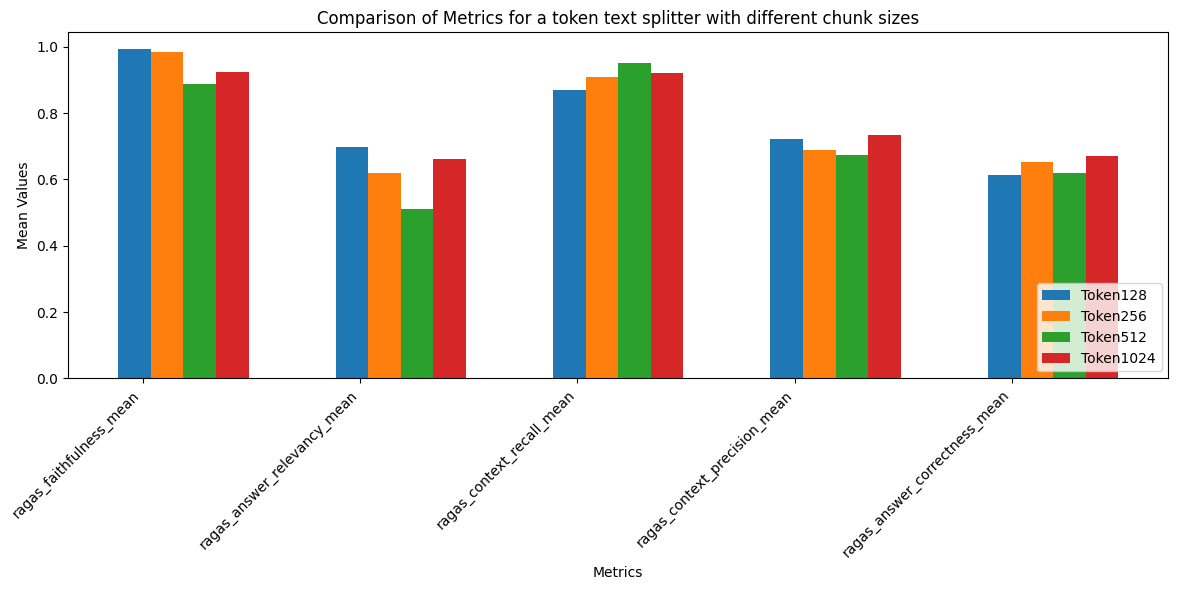

In [15]:
## 8.1.1.5 Review chunk size test results
import matplotlib.pyplot as plt


# Extract metric names and mean values
metric_names = list(ragas_eval_resultchunk1.keys())
ragas_eval_result1_means = list(ragas_eval_resultchunk1.values())
ragas_eval_result2_means = list(ragas_eval_resultchunk2.values())
ragas_eval_result3_means = list(ragas_eval_resultchunk3.values())
ragas_eval_result4_means = list(ragas_eval_resultchunk4.values())

# Create comparison chart
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.15
index = range(len(metric_names))

bar1 = ax.bar(index, ragas_eval_result1_means, bar_width, label='Token128')
bar2 = ax.bar([i + bar_width for i in index], ragas_eval_result2_means, bar_width, label='Token256')
bar3 = ax.bar([i + 2*bar_width for i in index], ragas_eval_result3_means, bar_width, label='Token512')
bar4 = ax.bar([i + 3*bar_width for i in index], ragas_eval_result4_means, bar_width, label='Token1024')

ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison of Metrics for a token text splitter with different chunk sizes')
ax.set_xticks([i + bar_width / 4 for i in index])
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend(loc='lower right')

plt.tight_layout()

# Save the figure
filename = './tmp/tokensplitter_chunksizes.png'
plt.savefig(filename)

plt.show()

In [17]:
# 8.1.1.6 LLM analysis
image_path = "./tmp/tokensplitter_chunksizes.png"
comparison = 'token splitter chunk size of 128 vs 256 vs 512 vs 1024'
result = ragas_eval.analze_ragas_result_chart(image_path, comparison)
print(result)

1. Analysis of the chart:
The chart compares the mean values of different RAGAS metrics (faithfulness, answer relevance, answer correctness, context recall, and context precision) for a token text splitter with different chunk sizes (128, 256, 512, and 1024).

2. Prioritizing the metrics:
If the metrics are prioritized in the order: 1) context recall, 2) context precision, 3) faithfulness, 4) answer relevance, and 5) answer correctness, the best-performing option is:
<best_prioritized>Token512</best_prioritized>

3. Use case and reasoning:
<best_prioritized_reason>
Token512 would be the best option if the primary goal is to maximize the context recall and context precision of the text splitter, which is crucial for applications like question-answering or information retrieval. The higher context recall and precision of Token512 indicate that it can effectively capture the relevant context from the input text, which is essential for providing accurate and informative responses. This opt

### 8.1.1.7 Review token splitter chunk size test results
Token1024 performs the best overall across all RAGAS metrics, and is also performing best across our prioritized set of metrics. This indicates that a chunk size of 1024 is the most well-rounded option for a token text splitter and more importantly is also a good option for our use case in which the preservation of the original text's context and meaning is of utmost importance. The 1024 chunk size performed well in all context related metrics, and combined with its strong faithfulness scores, ensures that the output of the text splitter maintains the essential characteristics of the original text, making it an ideal choice for this use case.

In [18]:
# 8.1.2.1 Chunk Size Eval with chunk_size=1000, chunk_overlap=64

rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'amazon.titan-embed-text-v1',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'approximate_search', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'rag-eval-chartextsplitter1000',
                        opensearch_index_dimension = 1536,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'RecursiveCharacterTextSplitter',
                        chunk_size =  1000,
                        chunk_overlap = 64,
                        debug = False 
                    )

rag_agent.index_documents(documents)
# wait to have bulk insert complete
time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultcharchunk1,ragas_eval_resultcharchunk1df = ragas_eval.run_ragas_eval(rag_system_eval_details)

trying to create new index
new index rag-eval-chartextsplitter1000 has been created.


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.


RAG system mean query time: 2.257142857142857
RAG system cost on ground truth set: 0.08229600000000001
ragas_faithfulness mean: 0.9904761904761905
ragas_answer_relevancy mean: 0.7238178275004016
ragas_context_recall mean:: 0.9081632653061223
ragas_context_precision mean: 0.7277777777481712
ragas_answer_correctness mean: 0.6685979010492366


In [19]:
# 8.1.2.2 Chunk Size Eval with chunk_size=1500, chunk_overlap=64

rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'amazon.titan-embed-text-v1',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'approximate_search', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'rag-eval-chartextsplitter1500',
                        opensearch_index_dimension = 1536,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'RecursiveCharacterTextSplitter',
                        chunk_size =  1500,
                        chunk_overlap = 64,
                        debug = False 
                    )

rag_agent.index_documents(documents)
# wait to have bulk insert complete
time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultcharchunk2,ragas_eval_resultcharchunk2df = ragas_eval.run_ragas_eval(rag_system_eval_details)

trying to create new index
new index rag-eval-chartextsplitter1500 has been created.


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.


RAG system mean query time: 2.51952380952381
RAG system cost on ground truth set: 0.10476599999999998
ragas_faithfulness mean: 0.8748214285714285
ragas_answer_relevancy mean: 0.7176649175838512
ragas_context_recall mean:: 0.86875
ragas_context_precision mean: 0.7017543859290205
ragas_answer_correctness mean: 0.7134877476357671


In [20]:
# 8.1.2.3 Chunk Size Eval with chunk_size=2000, chunk_overlap=64

rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'amazon.titan-embed-text-v1',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'approximate_search', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'rag-eval-chartextsplitter2000',
                        opensearch_index_dimension = 1536,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'RecursiveCharacterTextSplitter',
                        chunk_size =  2000,
                        chunk_overlap = 64,
                        debug = False 
                    )

rag_agent.index_documents(documents)
# wait to have bulk insert complete
time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultcharchunk3,ragas_eval_resultcharchunk3df = ragas_eval.run_ragas_eval(rag_system_eval_details)

trying to create new index
new index rag-eval-chartextsplitter2000 has been created.


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.


RAG system mean query time: 2.7976190476190474
RAG system cost on ground truth set: 0.122607
ragas_faithfulness mean: 0.9804166666666667
ragas_answer_relevancy mean: 0.5003783828970418
ragas_context_recall mean:: 0.8333333333333334
ragas_context_precision mean: 0.6915204678092592
ragas_answer_correctness mean: 0.6088577157258481


In [21]:
# 8.1.2.4 Chunk Size Eval with chunk_size=2500, chunk_overlap=64

rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'amazon.titan-embed-text-v1',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'approximate_search', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'rag-eval-chartextsplitter2500',
                        opensearch_index_dimension = 1536,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'RecursiveCharacterTextSplitter',
                        chunk_size =  2500,
                        chunk_overlap = 64,
                        debug = False 
                    )

rag_agent.index_documents(documents)
# wait to have bulk insert complete
time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultcharchunk4,ragas_eval_resultcharchunk4df = ragas_eval.run_ragas_eval(rag_system_eval_details)

trying to create new index
new index rag-eval-chartextsplitter2500 has been created.


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.


RAG system mean query time: 3.098095238095239
RAG system cost on ground truth set: 0.141744
ragas_faithfulness mean: 0.9285714285714286
ragas_answer_relevancy mean: 0.6564630658805788
ragas_context_recall mean:: 0.8571428571428571
ragas_context_precision mean: 0.6874999999620138
ragas_answer_correctness mean: 0.6589936557411485


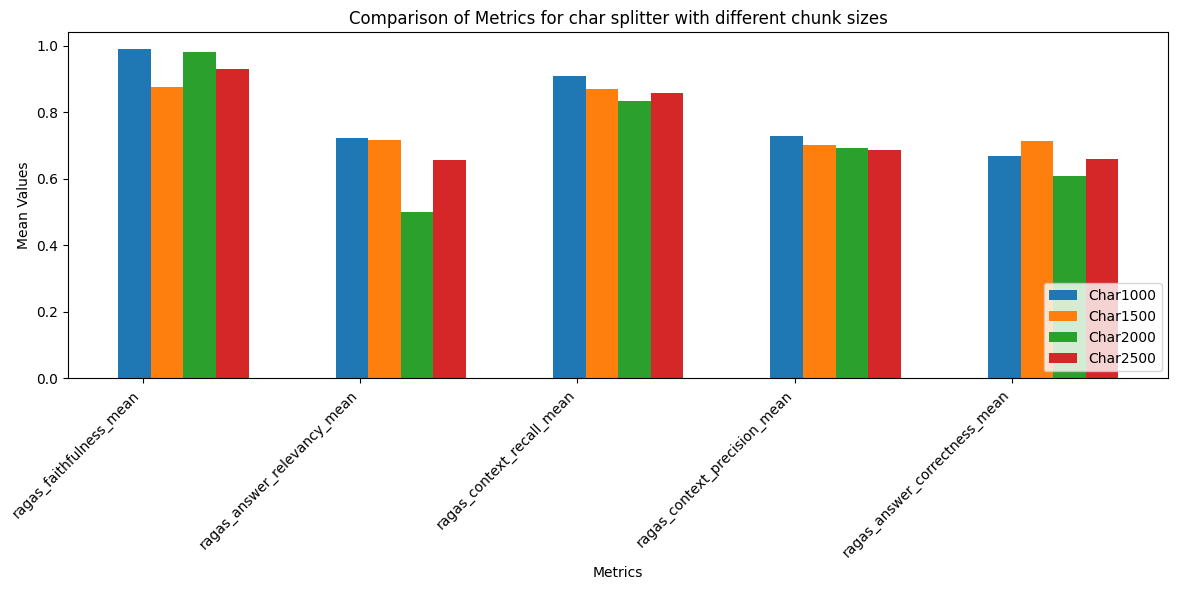

In [22]:
## 8.1.2.5 Review chunk size test results
import matplotlib.pyplot as plt


# Extract metric names and mean values
metric_names = list(ragas_eval_resultcharchunk1.keys())
ragas_eval_result1_means = list(ragas_eval_resultcharchunk1.values())
ragas_eval_result2_means = list(ragas_eval_resultcharchunk2.values())
ragas_eval_result3_means = list(ragas_eval_resultcharchunk3.values())
ragas_eval_result4_means = list(ragas_eval_resultcharchunk4.values())

# Create comparison chart
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.15
index = range(len(metric_names))

bar1 = ax.bar(index, ragas_eval_result1_means, bar_width, label='Char1000')
bar2 = ax.bar([i + bar_width for i in index], ragas_eval_result2_means, bar_width, label='Char1500')
bar3 = ax.bar([i + 2*bar_width for i in index], ragas_eval_result3_means, bar_width, label='Char2000')
bar4 = ax.bar([i + 3*bar_width for i in index], ragas_eval_result4_means, bar_width, label='Char2500')

ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison of Metrics for char splitter with different chunk sizes')
ax.set_xticks([i + bar_width / 4 for i in index])
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend(loc='lower right')

plt.tight_layout()

# Save the figure
filename = './tmp/charsplitter_chunksizes.png'
plt.savefig(filename)

plt.show()

In [23]:
# 8.1.2.6 LLM analysis
image_path = "./tmp/charsplitter_chunksizes.png"
comparison = 'recursive character text splitter chunk size of 1000 vs 1500 vs 2000 vs 2500'
result = ragas_eval.analze_ragas_result_chart(image_path, comparison)
print(result)


1. Analysis of the chart:
The chart shows the comparison of RAGAS metrics for a char splitter with different chunk sizes (1000, 1500, 2000, 2500). The metrics include faithfulness, answer relevance, answer correctness, context recall, and context precision.

2. Prioritized performance:
Based on the prioritized metrics of 1) context recall, 2) context precision, 3) faithfulness, 4) answer relevance, and 5) answer correctness, the best-performing option is:
<best_prioritized>Char2000</best_prioritized>

3. Potential use case and reason:
<best_prioritized_reason>
The Char2000 option may be suitable for applications that prioritize maintaining the context and relevance of the generated responses, such as dialogue systems or question-answering engines. This option performs better in the context recall and context precision metrics, indicating its ability to preserve the broader context and maintain the relevance of the generated responses. This could be beneficial in scenarios where maintai

### 8.1.2.7 Review recursive character text splitter chunk size test results
Char2500 performs the best overall across all RAGAS metrics, and is also performing best across our prioritized set of metrics.

### 8.1.3 chunk size test results
Token1024 and Char2500 performed best in this experiment, this is why we will compare the two in the next experiment below.

### 8.2) Evaluate impact of different text splitters

In this second eval, we keep everything else constant, and only change the splitter method.

In [24]:
# 8.2.1 RAG system with TokenTextSplitter

rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'amazon.titan-embed-text-v1',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'approximate_search', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'rag-eval-tokentextsplitter1024',
                        opensearch_index_dimension = 1536,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'TokenTextSplitter',
                        chunk_size =  1024,
                        chunk_overlap = 64,
                        debug = False 
                    )

rag_agent.index_documents(documents)
# wait to have bulk insert complete
time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultsplitter1,ragas_eval_resultsplitter1df = ragas_eval.run_ragas_eval(rag_system_eval_details)

trying to create new index
new index rag-eval-tokentextsplitter1024 has been created.


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.


RAG system mean query time: 3.7455
RAG system cost on ground truth set: 0.21576599999999999
ragas_faithfulness mean: 0.9204545454545455
ragas_answer_relevancy mean: 0.6479417889897862
ragas_context_recall mean:: 0.9333333333333333
ragas_context_precision mean: 0.7654320987288836
ragas_answer_correctness mean: 0.6739913386906732


In [25]:
# 8.2.2 RAG system with CharTextSplitter

rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'amazon.titan-embed-text-v1',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'approximate_search', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'rag-eval-chartextsplitter2000',
                        opensearch_index_dimension = 1536,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'RecursiveCharacterTextSplitter',
                        chunk_size =  2000,
                        chunk_overlap = 64,
                        debug = False 
                    )

rag_agent.index_documents(documents)
# wait to have bulk insert complete
time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultsplitter2,ragas_eval_resultsplitter2df = ragas_eval.run_ragas_eval(rag_system_eval_details)

trying to create new index
new index rag-eval-chartextsplitter2000 has been created.


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.


RAG system mean query time: 2.5461904761904766
RAG system cost on ground truth set: 0.12287699999999999
ragas_faithfulness mean: 0.994736842105263
ragas_answer_relevancy mean: 0.5003783828970418
ragas_context_recall mean:: 0.825
ragas_context_precision mean: 0.7249999999731249
ragas_answer_correctness mean: 0.6323207122717639


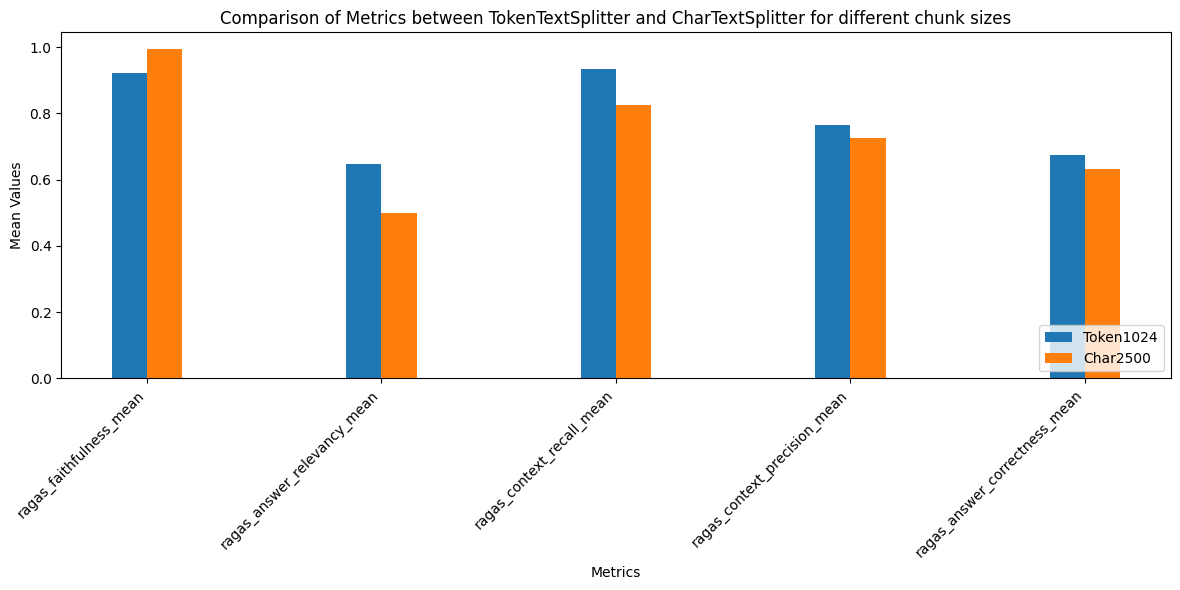

In [26]:
## 8.2.3 Review RecursiveCharacterTextSplitter vs TokenTextSplitter results
import matplotlib.pyplot as plt

# Extract metric names and mean values
metric_names = list(ragas_eval_resultsplitter1.keys())
ragas_eval_result1_means = list(ragas_eval_resultsplitter1.values())
ragas_eval_result2_means = list(ragas_eval_resultsplitter2.values())


# Create comparison chart
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.15
index = range(len(metric_names))

bar1 = ax.bar(index, ragas_eval_result1_means, bar_width, label='Token1024')
bar2 = ax.bar([i + bar_width for i in index], ragas_eval_result2_means, bar_width, label='Char2500')

ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison of Metrics between TokenTextSplitter and CharTextSplitter for different chunk sizes')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend(loc='lower right')

plt.tight_layout()
# Save the figure
filename = './tmp/tokensplitter_vs_charsplitter.png'
plt.savefig(filename)
plt.show()


In [27]:
# 8.2.4 LLM analysis
image_path = "./tmp/tokensplitter_vs_charsplitter.png"
comparison = 'recursive character text splitter with a chunk size of 2000 vs a token text splitter with a chunk size of 1024'
result = ragas_eval.analze_ragas_result_chart(image_path, comparison)
print(result)

1. The chart compares the mean values of different metrics between TokenTextSplitter (Token1024) and CharTextSplitter (Char2500) for various chunk sizes.

2. Based on the prioritized metrics of 1) context recall, 2) context precision, 3) faithfulness, 4) answer relevance, and 5) answer correctness, the best performing option is:
<best_prioritized>Token1024</best_prioritized>

3. The Token1024 option performs better compared to Char2500 in the prioritized metrics, making it a suitable choice for tasks that require high context recall, context precision, faithfulness, answer relevance, and answer correctness. This could be useful in applications such as question-answering systems, where preserving the context and providing relevant and faithful answers are crucial. The higher performance of Token1024 across the prioritized metrics suggests it can better capture the necessary information and deliver more accurate and reliable responses, which is essential for such applications.
<best_prio

### 8.2.5 Review RecursiveCharacterTextSplitter vs TokenTextSplitter results
The TokenTextSplitter outperformed the RecursiveCharacterTextSplitter across the prioritized set of metrics. 

### 8.3) Evaluate impact of different embeddings models

In this third eval, we proceed with the TokenTextSplitter.
Due to the difference in context window length of the the embedding models, we adjust the chunk size to 350 tokens for the Cohere models.

In [28]:
# 8.3.1 Create RAG system with amazon.titan-embed-text-v1

rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'amazon.titan-embed-text-v1',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'approximate_search', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'rag-eval-tokentextsplittertitanv1',
                        opensearch_index_dimension = 1536,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'TokenTextSplitter',
                        chunk_size =  1024,
                        chunk_overlap = 64,
                        debug = False 
                    )

rag_agent.index_documents(documents)
# wait to have bulk insert complete
time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultembedding1,ragas_eval_resultembedding1df = ragas_eval.run_ragas_eval(rag_system_eval_details)

trying to create new index
new index rag-eval-tokentextsplittertitanv1 has been created.


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.


RAG system mean query time: 3.546190476190476
RAG system cost on ground truth set: 0.21570899999999998
ragas_faithfulness mean: 0.8392361111111111
ragas_answer_relevancy mean: 0.5985556290592344
ragas_context_recall mean:: 0.9178571428571429
ragas_context_precision mean: 0.6547619047227512
ragas_answer_correctness mean: 0.4876067380009475


In [29]:
# 8.3.2 Create RAG system with amazon.titan-embed-text-v2:0

rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'amazon.titan-embed-text-v2:0',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'approximate_search', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'rag-eval-tokentextsplittertitanv2',
                        opensearch_index_dimension = 1024,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'TokenTextSplitter',
                        chunk_size =  1024,
                        chunk_overlap = 64,
                        debug = False 
                    )

rag_agent.index_documents(documents)
# wait to have bulk insert complete
time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultembedding2,ragas_eval_resultembedding2df = ragas_eval.run_ragas_eval(rag_system_eval_details)

trying to create new index
new index rag-eval-tokentextsplittertitanv2 has been created.


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.


RAG system mean query time: 3.493333333333333
RAG system cost on ground truth set: 0.225918
ragas_faithfulness mean: 0.9642857142857143
ragas_answer_relevancy mean: 0.7323865726027967
ragas_context_recall mean:: 0.9387755102040817
ragas_context_precision mean: 0.8450292397240253
ragas_answer_correctness mean: 0.7089380889530238


In [30]:
# 8.3.3 Create RAG system with cohere.embed-multilingual-v3

rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'cohere.embed-multilingual-v3',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'approximate_search', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'rag-eval-tokentextsplittercoherev3',
                        opensearch_index_dimension = 1024,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'TokenTextSplitter',
                        chunk_size =  350,
                        chunk_overlap = 25,
                        debug = False 
                    )

rag_agent.index_documents(documents)
# wait to have bulk insert complete
time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultembedding3,ragas_eval_resultembedding3df = ragas_eval.run_ragas_eval(rag_system_eval_details)

trying to create new index
new index rag-eval-tokentextsplittercoherev3 has been created.


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.


RAG system mean query time: 2.8704761904761904
RAG system cost on ground truth set: 0.11606099999999998
ragas_faithfulness mean: 1.0
ragas_answer_relevancy mean: 0.784211481460956
ragas_context_recall mean:: 0.8707142857142858
ragas_context_precision mean: 0.8915343914895282
ragas_answer_correctness mean: 0.7398476435223612


In [32]:
# 8.3.4 Create RAG system with cohere.embed-english-v3

rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'cohere.embed-english-v3',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'approximate_search', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'rag-eval-tokentextsplittercohere-eng-v3',
                        opensearch_index_dimension = 1024,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'TokenTextSplitter',
                        chunk_size =  350,
                        chunk_overlap = 25,
                        debug = False 
                    )

rag_agent.index_documents(documents)
# wait to have bulk insert complete
time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultembedding4,ragas_eval_resultembedding4df = ragas_eval.run_ragas_eval(rag_system_eval_details)

trying to create new index
new index rag-eval-tokentextsplittercohere-eng-v3 has been created.


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.


RAG system mean query time: 2.369047619047619
RAG system cost on ground truth set: 0.11696999999999999
ragas_faithfulness mean: 0.980952380952381
ragas_answer_relevancy mean: 0.798529395627204
ragas_context_recall mean:: 0.9023809523809524
ragas_context_precision mean: 0.8388888888532176
ragas_answer_correctness mean: 0.7197933823270635


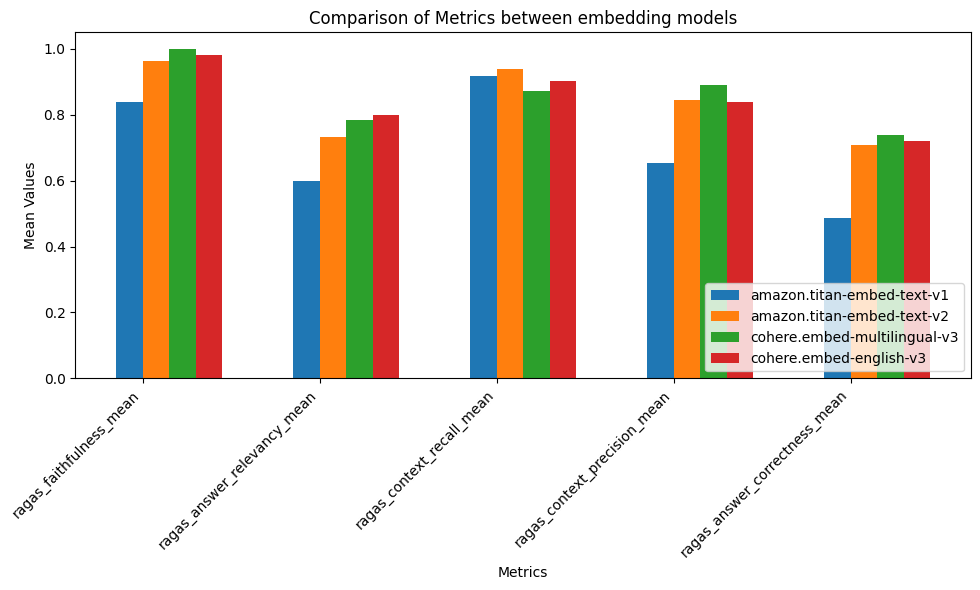

In [33]:
# 8.3.5 Review embedding models

import matplotlib.pyplot as plt

# Extract metric names and mean values
metric_names = list(ragas_eval_resultembedding1.keys())
ragas_eval_result1_means = list(ragas_eval_resultembedding1.values())
ragas_eval_result2_means = list(ragas_eval_resultembedding2.values())
ragas_eval_result3_means = list(ragas_eval_resultembedding3.values())
ragas_eval_result4_means = list(ragas_eval_resultembedding4.values())

# Create comparison chart
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.15
index = range(len(metric_names))

bar1 = ax.bar(index, ragas_eval_result1_means, bar_width, label='amazon.titan-embed-text-v1')
bar2 = ax.bar([i + bar_width for i in index], ragas_eval_result2_means, bar_width, label='amazon.titan-embed-text-v2')
bar3 = ax.bar([i + 2*bar_width for i in index], ragas_eval_result3_means, bar_width, label='cohere.embed-multilingual-v3')
bar4 = ax.bar([i + 3*bar_width for i in index], ragas_eval_result4_means, bar_width, label='cohere.embed-english-v3')

ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison of Metrics between embedding models')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend(loc='lower right')

plt.tight_layout()

# Save the figure
filename = './tmp/embeddingmodels_comparison.png'
plt.savefig(filename)

plt.show()

In [35]:
# 8.3.4 LLM analysis
image_path = "./tmp/embeddingmodels_comparison.png"
comparison = 'Comparison of amazon.titan-embed-text-v1 embedding model with a chunk size of 1024, amazon.titan-embed-text-v2 embedding model with a chunk size of 1024, cohere.embed-multilingual-v3 embedding model with a chunk size of 350, and , cohere.embed-english-v3 embedding model with a chunk size of 350'
result = ragas_eval.analze_ragas_result_chart(image_path, comparison)
print(result)

1. The chart compares the performance of different embedding models across various metrics, including faithfulness, answer relevance, answer correctness, context recall, and context precision.

2. Based on the prioritized metrics (1) context recall, (2) context precision, (3) faithfulness, (4) answer relevance, and (5) answer correctness, the best-performing option is:
<best_prioritized>cohere.embed-multilingual-v3</best_prioritized>

3. Use case and reasoning:
<best_prioritized_reason>
The cohere.embed-multilingual-v3 model appears to be the best choice if the primary goal is to maximize context recall and context precision, which are crucial for tasks such as question answering, information retrieval, and text summarization. This model outperforms the other options in these two key metrics, while also performing well in terms of faithfulness, answer relevance, and answer correctness. This makes it a versatile choice for applications that require a balance of accurate and relevant res

### 8.3.5 Review Embedding models
Here we can observe that for context recall, context precision, and faithfulness cohere.embed-multilingual-v3 performs better than any of the other embedding models, even at a much smaller token chunk size such as 350.
We can also observe that amazon.titan-embed-text-v2 outperforms amazon.titan-embed-text-v1 signficantly. Further, even though the content is in English, the cohere.embed-english-v3 is outperformed by cohere.embed-multilingual-v3.
 
As a result, we will proceed the next eval with cohere.embed-multilingual-v3 .

### 8.4) Evaluate impact of different retriever search types

In [36]:
# 8.4.1 Create RAG system with Opensearch's “similarity”/approximate_search retriever
rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'cohere.embed-multilingual-v3',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'approximate_search', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'rag-eval-tokentextsplittercohere-eng-v3-approximate_search',
                        opensearch_index_dimension = 1024,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'TokenTextSplitter',
                        chunk_size =  350,
                        chunk_overlap = 25,
                        debug = False 
                    )

rag_agent.index_documents(documents)
# wait to have bulk insert complete
time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultretriever1, ragas_eval_resultretriever1df = ragas_eval.run_ragas_eval(rag_system_eval_details)

trying to create new index
Index rag-eval-tokentextsplittercohere-eng-v3-approximate_search not found. Creating index on OpenSearch.
new index rag-eval-tokentextsplittercohere-eng-v3-approximate_search has been created.


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.
Failed to parse output. Returning None.


RAG system mean query time: 2.2323809523809524
RAG system cost on ground truth set: 0.11604599999999998
ragas_faithfulness mean: 1.0
ragas_answer_relevancy mean: 0.7847890611759529
ragas_context_recall mean:: 0.8707142857142858
ragas_context_precision mean: 0.8861111110660879
ragas_answer_correctness mean: 0.7441728958700567


In [37]:
# 8.4.2 Create RAG system with Opensearch's “mmr” retriever
rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'cohere.embed-multilingual-v3',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'mmr', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'rag-eval-tokentextsplittercohere-eng-v3-mmr_search',
                        opensearch_index_dimension = 1024,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'TokenTextSplitter',
                        chunk_size =  350,
                        chunk_overlap = 25,
                        debug = False 
                    )

rag_agent.index_documents(documents)
# wait to have bulk insert complete
time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultretriever2, ragas_eval_resultretriever2df = ragas_eval.run_ragas_eval(rag_system_eval_details)

trying to create new index
Index rag-eval-tokentextsplittercohere-eng-v3-mmr_search not found. Creating index on OpenSearch.
new index rag-eval-tokentextsplittercohere-eng-v3-mmr_search has been created.


Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.
Failed to parse output. Returning None.


RAG system mean query time: 2.1514285714285712
RAG system cost on ground truth set: 0.11517599999999999
ragas_faithfulness mean: 0.9625
ragas_answer_relevancy mean: 0.7439902850485437
ragas_context_recall mean:: 0.8702380952380953
ragas_context_precision mean: 0.8584656084225748
ragas_answer_correctness mean: 0.7073169690530277


In [45]:
# 8.4.3 Create RAG system with Bedrock Knowledge Base retriever

rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'cohere.embed-multilingual-v3',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'bedrock_kb', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'bedrock-kb-eval', # setting not used with Bedrock KB 
                        opensearch_index_dimension = 1024, # setting not used with Bedrock KB 
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'TokenTextSplitter', # setting not used with Bedrock KB 
                        chunk_size =  350, # setting not used with Bedrock KB 
                        chunk_overlap = 25, # setting not used with Bedrock KB 
                        debug = False 
                    )

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultretriever3, ragas_eval_resultretriever3df = ragas_eval.run_ragas_eval(rag_system_eval_details)

Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Failed to parse output. Returning None.
No statements were generated from the answer.
Failed to parse output. Returning None.
Failed to parse output. Returning None.


RAG system mean query time: 4.201904761904761
RAG system cost on ground truth set: 0.416106
ragas_faithfulness mean: 0.9125
ragas_answer_relevancy mean: 0.5733859741613485
ragas_context_recall mean:: 0.9285714285714286
ragas_context_precision mean: 0.695603908193139
ragas_answer_correctness mean: 0.6416923419593525


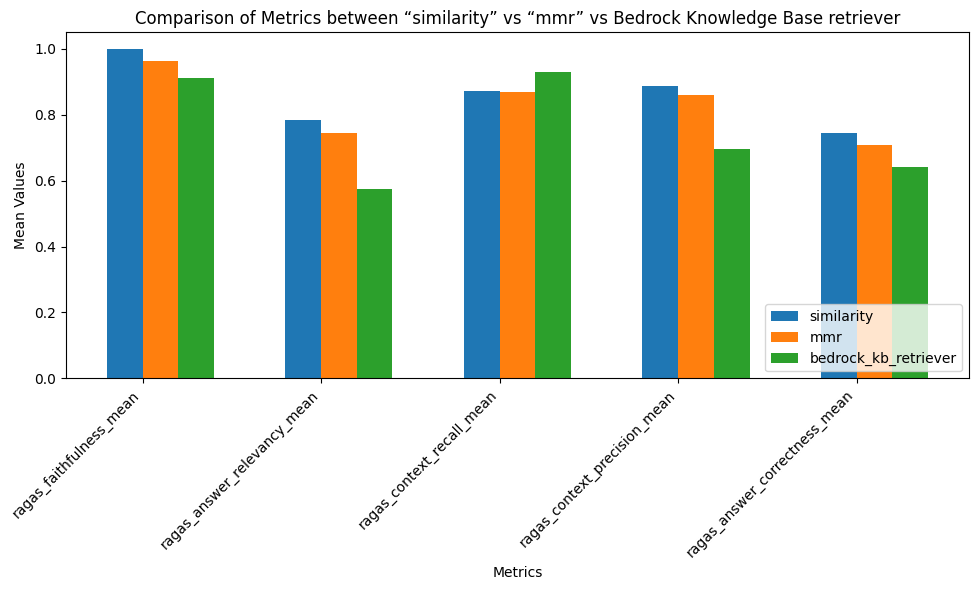

In [46]:
# 8.4.4 Review “similarity” vs “mmr” vs Bedrock Knowledge Base retriever results

import matplotlib.pyplot as plt


# Extract metric names and mean values
metric_names = list(ragas_eval_resultretriever1.keys())
ragas_eval_result1_means = list(ragas_eval_resultretriever1.values())
ragas_eval_result2_means = list(ragas_eval_resultretriever2.values())
ragas_eval_result3_means = list(ragas_eval_resultretriever3.values())

# Create comparison chart
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.20
index = range(len(metric_names))

bar1 = ax.bar(index, ragas_eval_result1_means, bar_width, label='similarity')
bar2 = ax.bar([i + bar_width for i in index], ragas_eval_result2_means, bar_width, label='mmr')
bar3 = ax.bar([i + 2*bar_width for i in index], ragas_eval_result3_means, bar_width, label='bedrock_kb_retriever')
ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison of Metrics between “similarity” vs “mmr” vs Bedrock Knowledge Base retriever')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend(loc='lower right')

plt.tight_layout()
# Save the figure
filename = './tmp/retriever_comparison.png'
plt.savefig(filename)
plt.show()

In [47]:
# 8.4.5 LLM analysis
image_path = "./tmp/retriever_comparison.png"
comparison = 'Comparing similarity with mmr and bedrock_kb retriever'
result = ragas_eval.analze_ragas_result_chart(image_path, comparison)
print(result)

1. Analysis of the chart:
The chart shows a comparison of three metrics: "similarity", "mmr", and "bedrock_kb_retriever" across five different metrics - faithfulness, answer relevance, answer correctness, context recall, and context precision.

2. Prioritizing the metrics:
Based on the prioritization of the metrics (1) context recall, (2) context precision, (3) faithfulness, (4) answer relevance, and (5) answer correctness, the best-performing option is:
<best_prioritized>bedrock_kb_retriever</best_prioritized>

3. Reason and use case:
<best_prioritized_reason>
The bedrock_kb_retriever option performs the best when the metrics are prioritized in the given order. It excels in context recall and context precision, which are the top priorities. While it may not be the best in answer relevance and correctness, its strong performance in context-related metrics makes it a suitable choice for use cases where retrieving the most relevant context is crucial, such as in knowledge-intensive tasks

### 8.4.6 Review “similarity” vs “mmr” vs Bedrock Knowledge Base retriever results

Bedrock's Knowledge Base Retriever with the Cohere embeddings model and default settings emerges as the best retriever.



### 8.5) Evaluate impact of different prompt templates

In [49]:
# 8.5.1 Create RAG system with PROMPT_CLAUDE_1

rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'cohere.embed-multilingual-v3',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_1,
                        search_method = 'bedrock_kb', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'bedrock_kb',
                        opensearch_index_dimension = 1024,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'TokenTextSplitter',
                        chunk_size =  350,
                        chunk_overlap = 25,
                        debug = False 
                    )

# rag_agent.index_documents(documents)
# # wait to have bulk insert complete
# time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultprompt1, ragas_eval_resultprompt1df = ragas_eval.run_ragas_eval(rag_system_eval_details)

Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

No statements were generated from the answer.
Failed to parse output. Returning None.
No statements were generated from the answer.
Failed to parse output. Returning None.
No statements were generated from the answer.
Failed to parse output. Returning None.


RAG system mean query time: 3.4961904761904754
RAG system cost on ground truth set: 0.417276
ragas_faithfulness mean: 0.9558823529411765
ragas_answer_relevancy mean: 0.5724985313290962
ragas_context_recall mean:: 0.925
ragas_context_precision mean: 0.7165281228787689
ragas_answer_correctness mean: 0.6949702248935624


In [51]:
# 8.5.2 Create RAG system with PROMPT_CLAUDE_2

rag_agent = RagAgent(   model_id = 'anthropic.claude-3-sonnet-20240229-v1:0',
                        embedding_model_id = 'cohere.embed-multilingual-v3',
                        top_k = 20,
                        top_p = 0.7,
                        temperature = 0.0,
                        max_token_count = 4000,
                        prompt_template = prompt_template_claude_2,
                        search_method = 'bedrock_kb', # 'approximate_search' / 'mmr' / 'bedrock_kb'
                        knowledge_base_id = os.environ['BEDROCK_KNOWLEDGEBASE_ID'],
                        region = os.environ['REGION'],
                        opensearch_endpoint = os.environ['OPENSEARCH_COLLECTION'],
                        opensearch_index = 'bedrock_kb',
                        opensearch_index_dimension = 1024,
                        opensearch_fetch_k = 4, # OpenSearch default
                        documents = documents,
                        chunking_strategy = 'TokenTextSplitter',
                        chunk_size =  350,
                        chunk_overlap = 25,
                        debug = False 
                    )

# rag_agent.index_documents(documents)
# # wait to have bulk insert complete
# time.sleep(60)

ragas_eval = RagasEval()
rag_system_eval_details = {
    "rag_agent": rag_agent,
    "ground_truth": prompts,
    "experiment_name": experiment_name
}

ragas_eval_resultprompt2, ragas_eval_resultprompt2df = ragas_eval.run_ragas_eval(rag_system_eval_details)

Evaluating:   0%|          | 0/105 [00:00<?, ?it/s]

Task exception was never retrieved
future: <Task finished name='Task-2528' coro=<as_completed.<locals>.sema_coro() done, defined at /home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/ragas/executor.py:36> exception=AssertionError('LLM is not set')>
Traceback (most recent call last):
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/ragas/executor.py", line 38, in sema_coro
    return await coro
           ^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/ragas/executor.py", line 112, in wrapped_callable_async
    return counter, await callable(*args, **kwargs)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/ragas/metrics/base.py", line 116, in ascore
    raise e
  File "/home/sagemaker-user/.conda/envs/rag_eval/lib/python3.11/site-packages/ragas/metrics/base.py", line 112, in ascore
    score = await self._ascore(row

RAG system mean query time: 4.963333333333333
RAG system cost on ground truth set: 0.447489
ragas_faithfulness mean: 0.9523809523809523
ragas_answer_relevancy mean: 0.8204844435301976
ragas_context_recall mean:: 0.9285714285714286
ragas_context_precision mean: 0.7140307548000768
ragas_answer_correctness mean: 0.8633243690486435


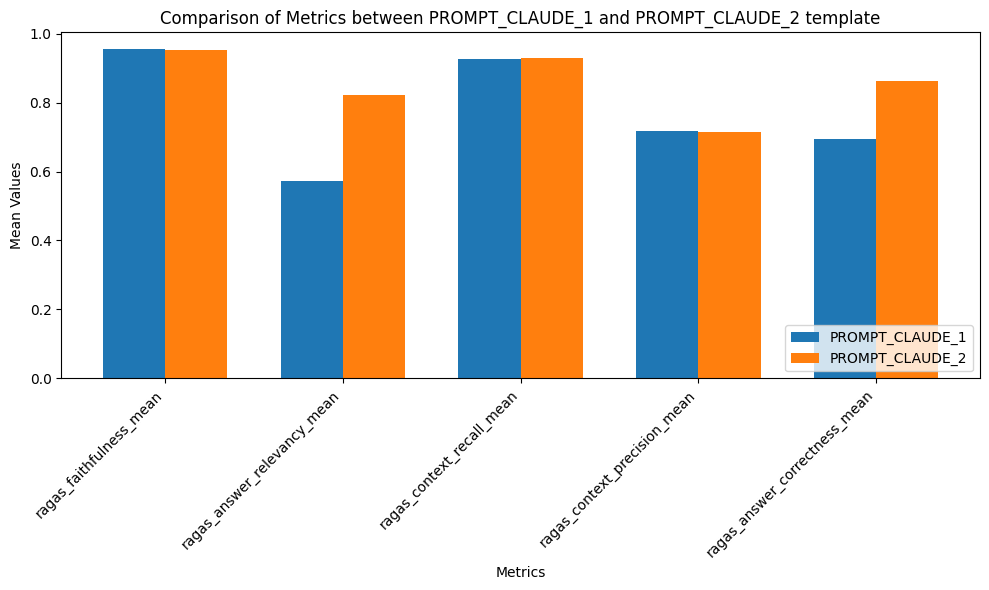

In [52]:
# 8.5.3 Review PROMPT_CLAUDE_1 vs PROMPT_CLAUDE_2 results

import matplotlib.pyplot as plt
  
# Extract metric names and mean values
metric_names = list(ragas_eval_resultprompt1.keys())
ragas_eval_result1_means = list(ragas_eval_resultprompt1.values())
ragas_eval_result2_means = list(ragas_eval_resultprompt2.values())

# Create comparison chart
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = range(len(metric_names))

bar1 = ax.bar(index, ragas_eval_result1_means, bar_width, label='PROMPT_CLAUDE_1')
bar2 = ax.bar([i + bar_width for i in index], ragas_eval_result2_means, bar_width, label='PROMPT_CLAUDE_2')

ax.set_xlabel('Metrics')
ax.set_ylabel('Mean Values')
ax.set_title('Comparison of Metrics between PROMPT_CLAUDE_1 and PROMPT_CLAUDE_2 template')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(metric_names, rotation=45, ha='right')
ax.legend(loc='lower right')

plt.tight_layout()
# Save the figure
filename = './tmp/prompttemplate_comparison.png'
plt.savefig(filename)

plt.show()

### 8.5.4 Review PROMPT_CLAUDE_1 vs PROMPT_CLAUDE_2 results

Overall comparable performance between the two prompt templates. Other factors such as prompt length/cost should be considered in addition to the above performance results.


# Conclusion

In our benchmark here, a token text splitter with a chunk size of 350 and a chunk overlap of 25 worked well in combination with Cohere's embeddings model. Amazon Bedrock's Knowledge Base Retriever with Cohere's embedding model and default settings performed even slightly better across our prioritized RAGAS metrics compared to our own OpenSearch retriever implementation various chunking strategies and search types on the given dataset.

But more important than the specific benchmark results above, we established that there is no one size fits all approach and instead demonstrated a metric driven development approach to optimize the retrieval performance of a RAG system, which you can apply to your own data, RAG system, and use case.


# Things to improve

- Compare more advanced retrieval methods and more advanced prompt templates.
- Include speed and cost dimension in analysis for entire RAG system (including embedding model and not just LLM) and for entire RAG eval system with RAGAS.